In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/instquality/")

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/instquality/")

import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load and merge

In [ ]:
# you will need

pip install country_converter
pip install sdmx1

# alongside colab built-in packages

In [ ]:
from functions.load import *

datasets = load()

(efw, # economic freedom of the world, fraser institute, 1970-2021
 fiw, # freedom in the world, freedom house, 2006-2023
 ief, # index of economic freedom, heritage foundation, 1995-2023
 p5d, # polity5d, polity project, 1960-2020
 pts, # political terror scale, 1976-2022
 wgi, # world governance indicators, world bank, 1996-2022
 wb, # institutional quality data + macro data (control), world bank, 1960-2023
 tgt # 10y sovereign yields (target), OECD and world bank, 1960-2024

) = (datasets[k] for k in ["efw", "fiw", "ief", "p5d", "pts", "wgi", "wb", "tgt"])

Loading files/EFW.xlsx
Loading files/FIW.xlsx
Loading files/IEF.csv
Loading files/P5D.xls
Loading files/PTS.xlsx
Loading files/WGI.xlsx
Loading files/WB_DATA.zip
Loading files/OECD.csv


In [ ]:
from functions.merge import *

dfs = [efw, fiw, ief, p5d, pts, wgi, wb, tgt]
names = ['efw', 'fiw', 'ief', 'p5d', 'pts', 'wgi', 'wb', 'tgt']

conc = create_concordance(dfs)

for i, name in enumerate(names):
    dfs[i] = apply_concordance(dfs[i], conc, name)

efw, fiw, ief, p5d, pts, wgi, wb, tgt = dfs

cdfs = [df.drop_duplicates(subset=['country', 'year'])
        for df in dfs]

merged = merge(cdfs, conc)

Removed from efw: []
Removed from fiw: ['Abkhazia' 'Antigua and Barbuda' 'Chechnya' 'Crimea' 'Eastern Donbas'
 'Gaza Strip' 'Indian Kashmir' 'Israeli Occupied Territories' 'Kiribati'
 'Marshall Islands' 'Micronesia' 'Nagorno-Karabakh' 'Northern Cyprus'
 'Pakistani Kashmir' 'Palau' 'Samoa' 'Solomon Islands' 'Somaliland'
 'South Ossetia' 'St. Kitts and Nevis' 'St. Lucia'
 'St. Vincent and the Grenadines' 'Tibet' 'Tonga' 'Transnistria' 'Tuvalu'
 'Vanuatu']
Removed from ief: ['Kiribati' 'Micronesia' 'Saint Lucia' 'Saint Vincent and the Grenadines'
 'Samoa' 'Solomon Islands' 'Tonga' 'Vanuatu']
Removed from p5d: ['Solomon Islands' 'South Vietnam' 'Vietnam North' 'Yemen North'
 'Yemen South']
Removed from pts: ['Antigua and Barbuda' 'Crimea' 'European Union' 'Gaza (Hamas)'
 'Israel in Occupied Territories' 'Israel in pre-1967 borders' 'Kiribati'
 'Marshall Islands' 'Micronesia, Federated States of' 'Palau'
 'Russia-Occupied Areas (Ukraine)' 'Saint Kitts and Nevis' 'Saint Lucia'
 'Saint Vincen

In [ ]:
# save

merged.to_pickle("saved/merged.dat")

## Institutional quality variables

In [ ]:
# reload

import pandas as pd

df = pd.read_pickle("saved/merged.dat")

In [ ]:
# show number of vars per source

prefixes = ["efw", "fiw", "ief", "p5d", "pts", "wgi", "wb", "tgt"]
col_counts = {p: sum(c.startswith(p + "_") for c in df.columns)
              for p in prefixes}

print("Number of variables per source:")
print(pd.Series(col_counts).astype(int).to_string())

Number of variables per source:
efw    79
fiw    16
ief    13
p5d    17
pts     6
wgi    36
wb     46
tgt     1


In [ ]:
# see var names per source

prefix = 'ief'

cols = [c for c in df.columns if c.startswith(f"{prefix}_")]
print(f"Found {len(cols)} {prefix} columns:")
print("\n".join(cols))

Found 13 ief columns:
ief_overall_score
ief_property_rights
ief_judicial_effectiveness
ief_government_integrity
ief_tax_burden
ief_government_spending
ief_fiscal_health
ief_business_freedom
ief_labor_freedom
ief_monetary_freedom
ief_trade_freedom
ief_investment_freedom
ief_financial_freedom


### Coverage

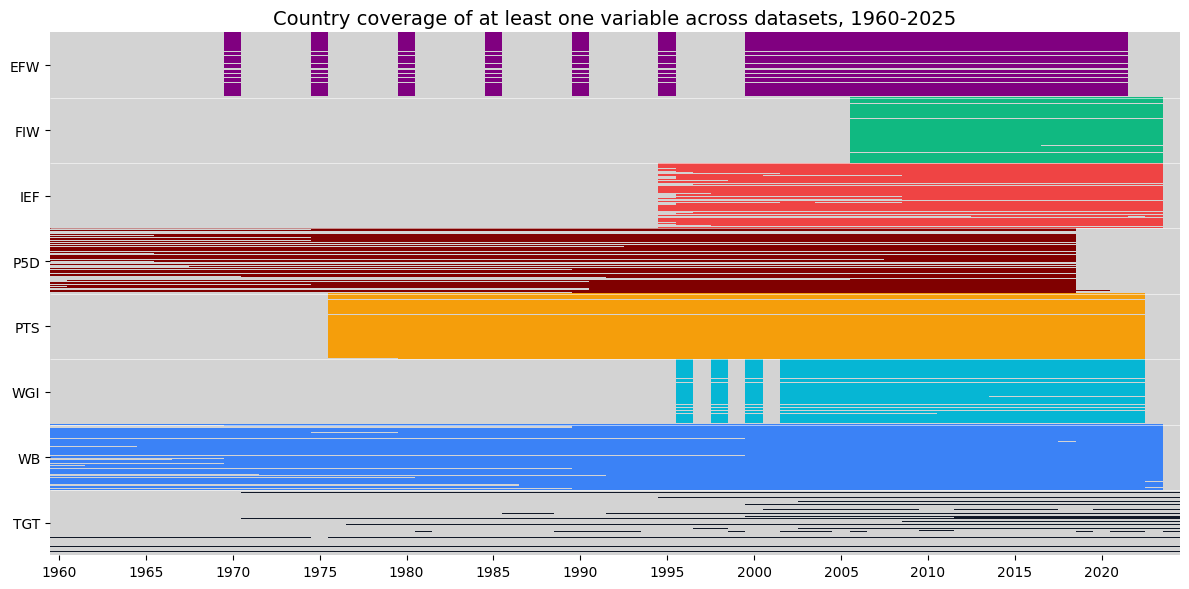

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Country coverage of at least one variable across datasets, 1960-2025'}>)

In [ ]:
# see coverage per source and year

from functions.plot import coverage_panel

prefixes = ["efw", "fiw", "ief", "p5d", "pts", "wgi", "wb", "tgt"]
coverage_panel(df, prefixes, start=1960, end=2024, missing_color='lightgrey')

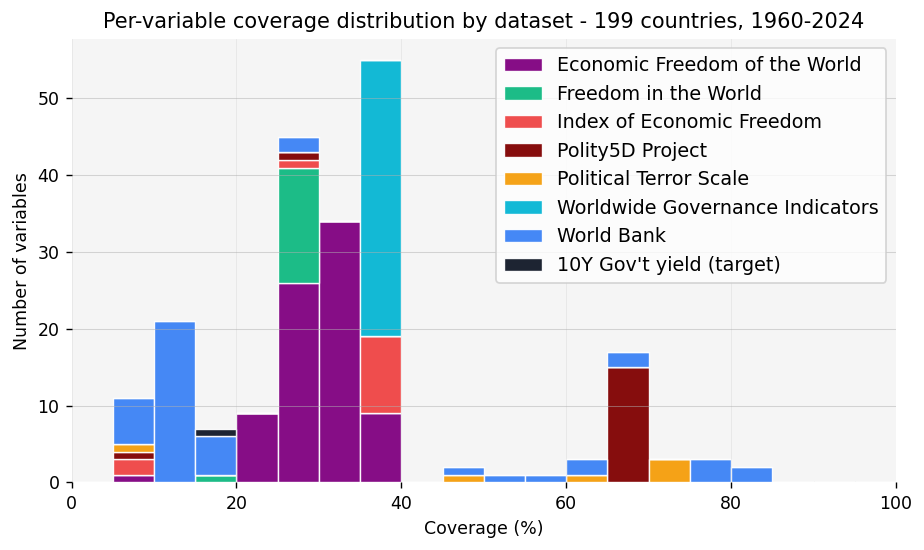

In [ ]:
# coverage histogram

from functions.plot import coverage_per_variable

coverage_per_variable(df)

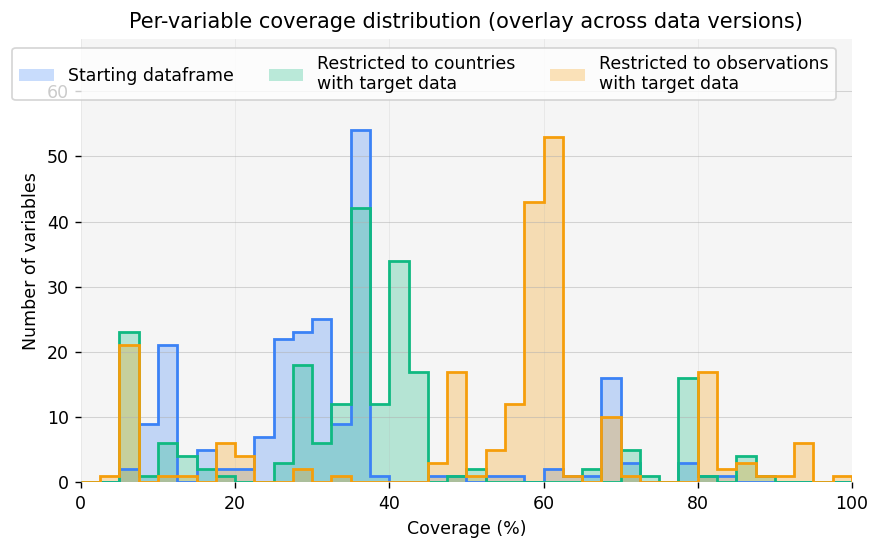

In [ ]:
# coverage histogram per dataset iteration

from functions.plot import coverage_per_version

coverage_per_version(df)

### Timeseries

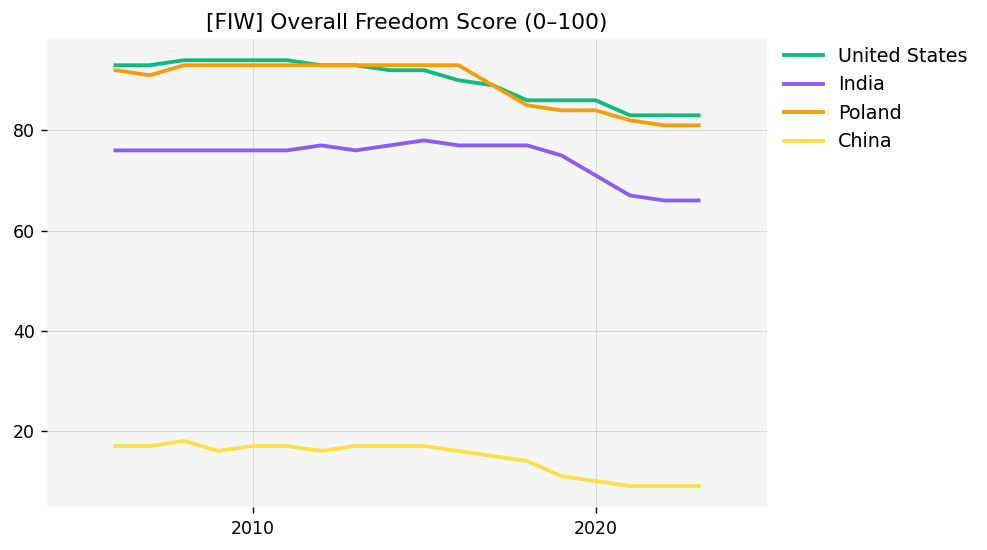

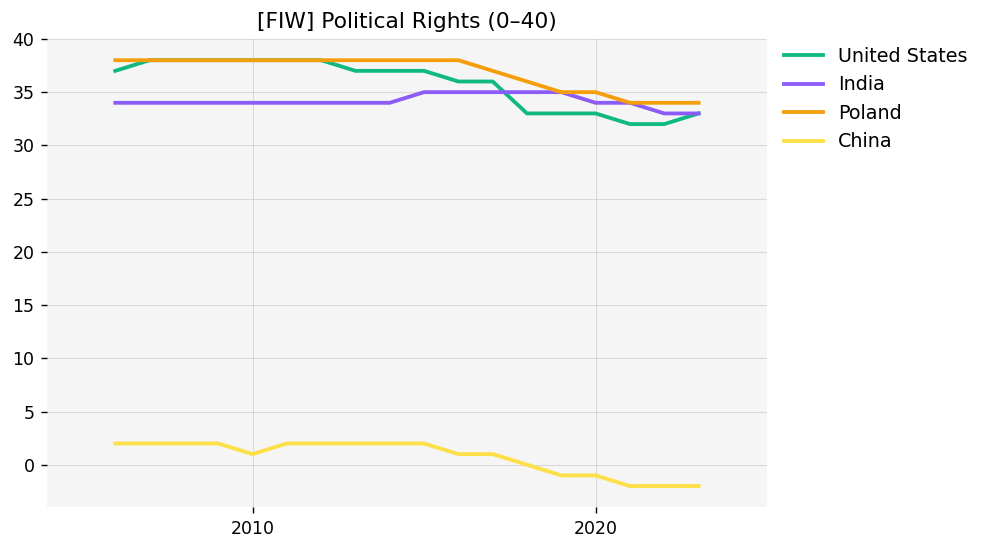

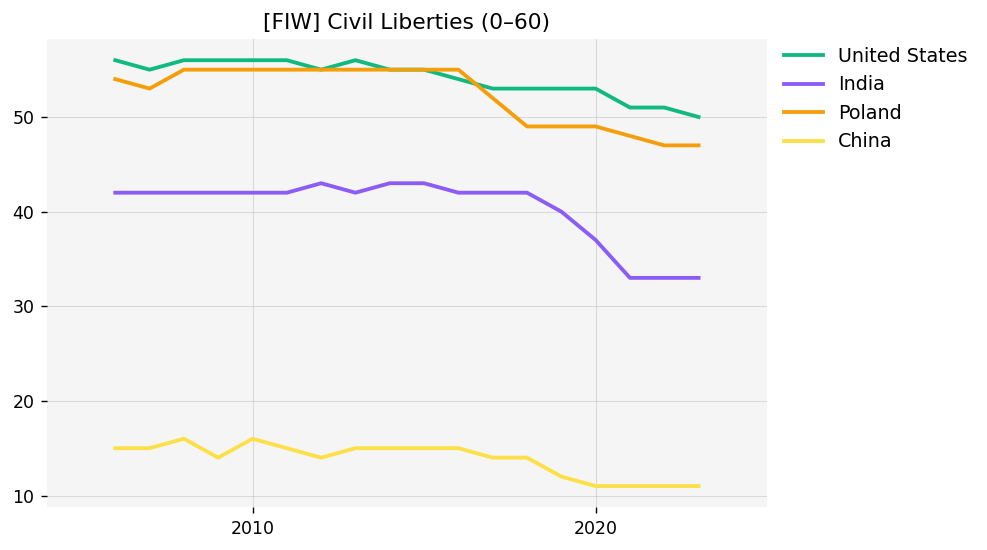

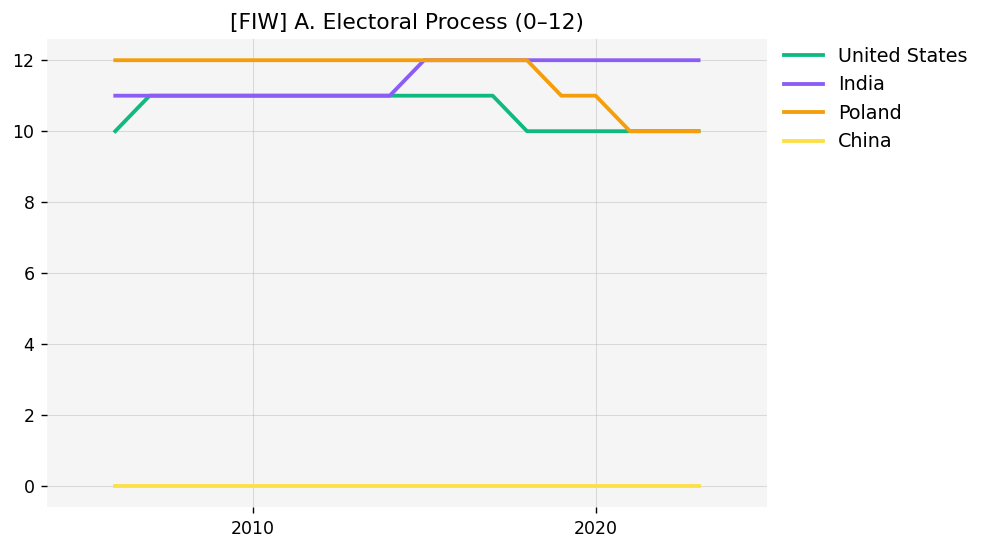

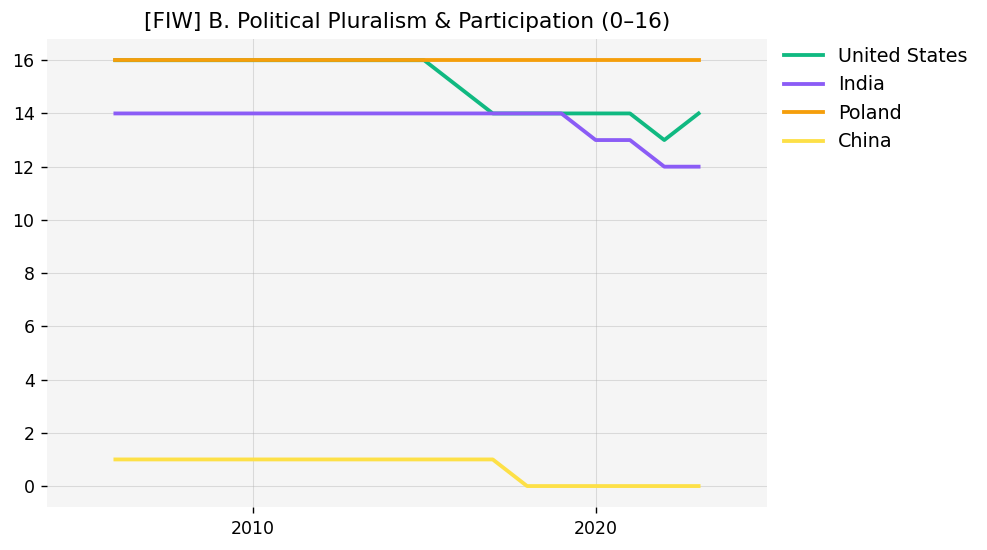

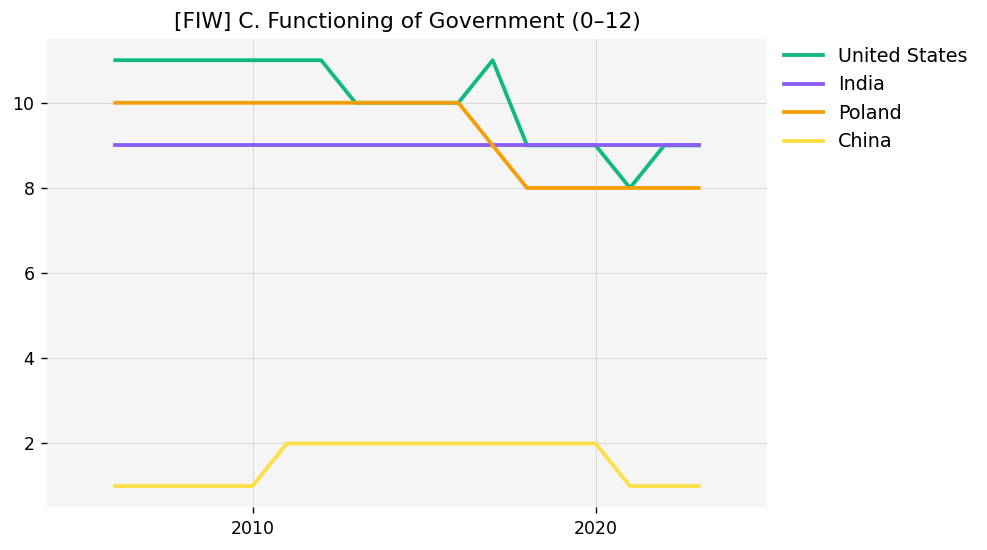

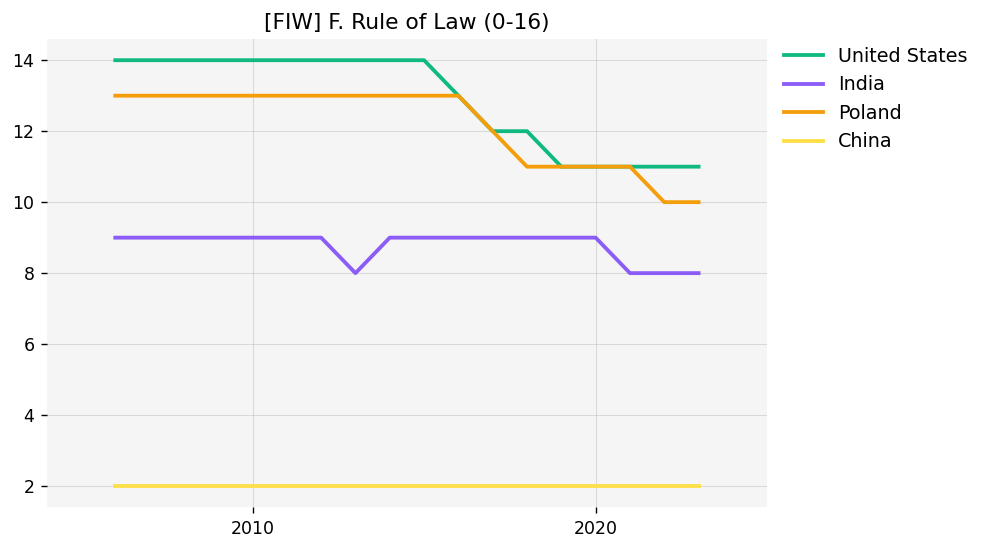

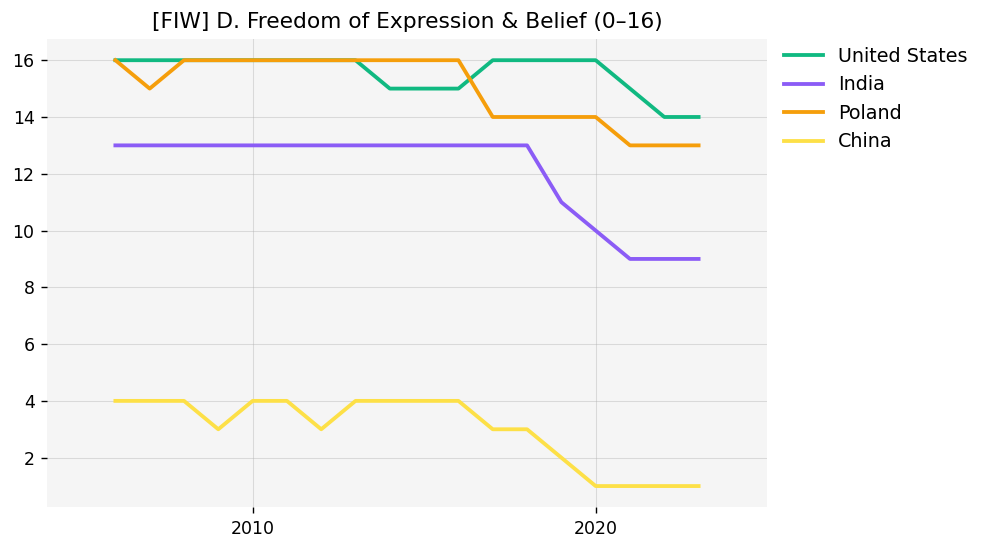

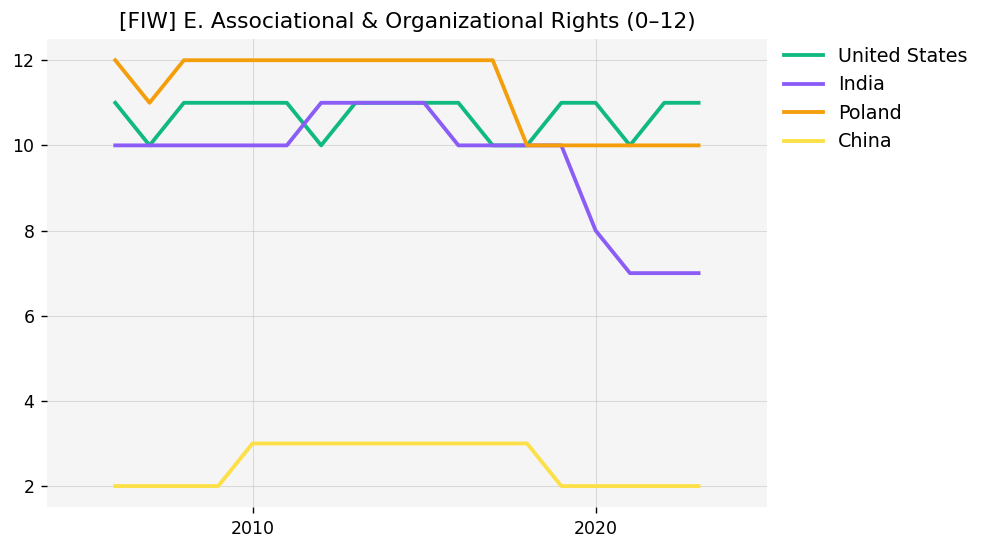

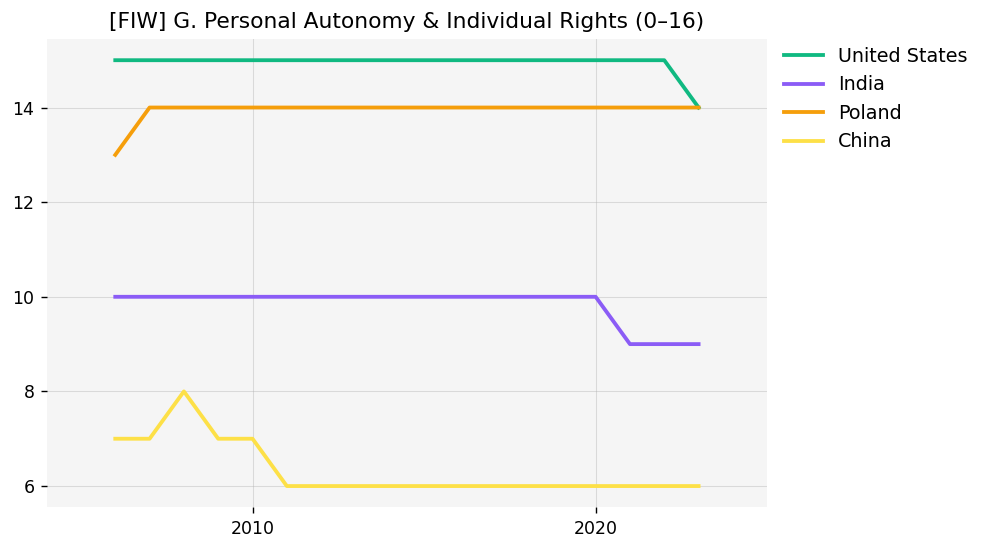

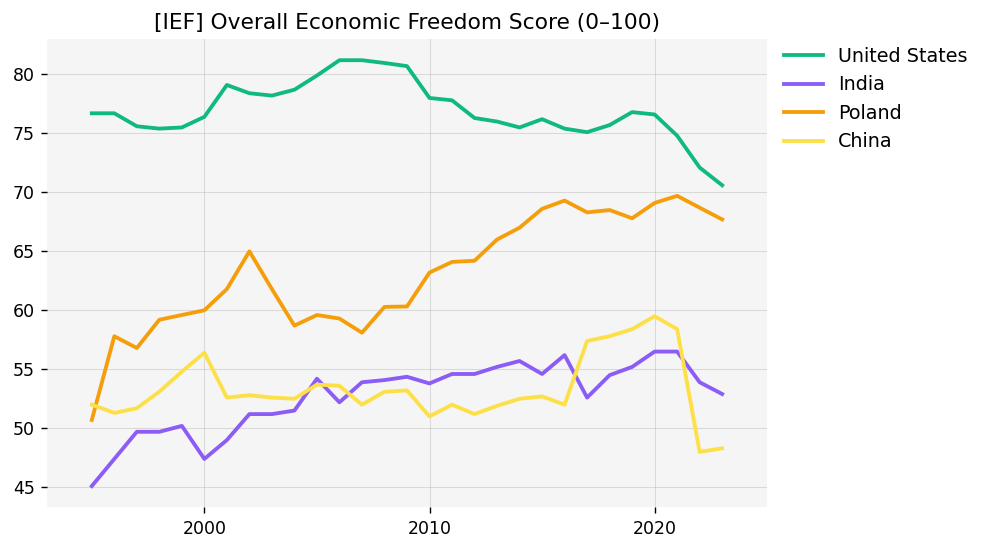

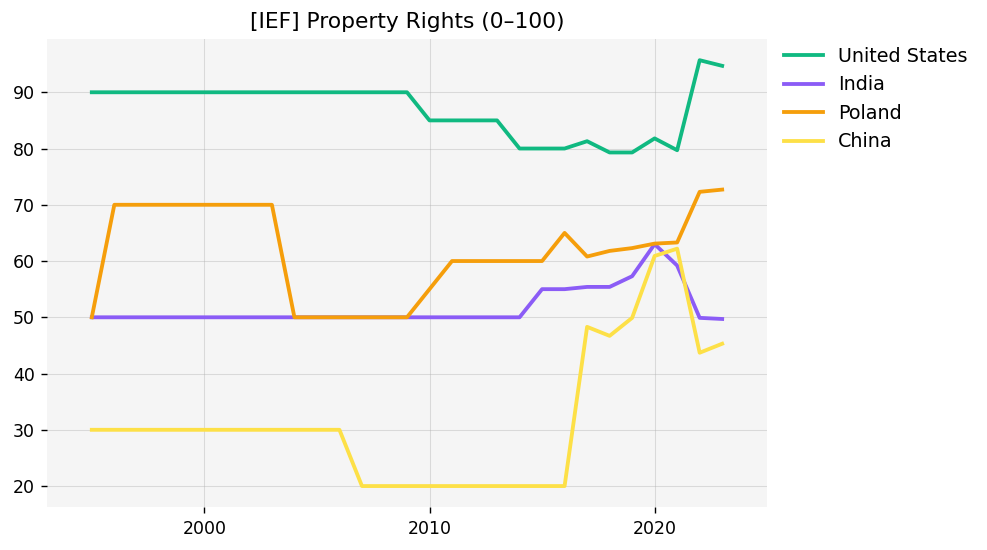

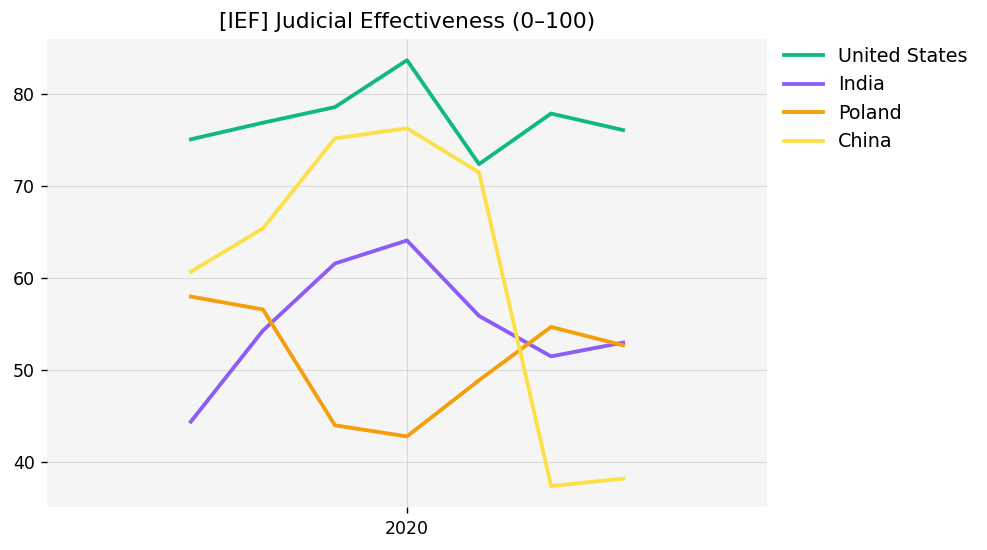

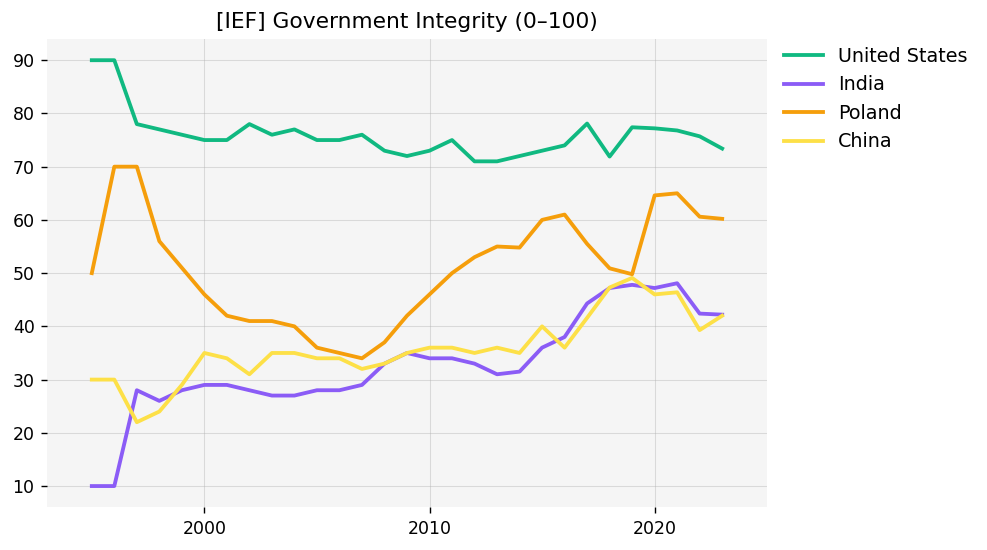

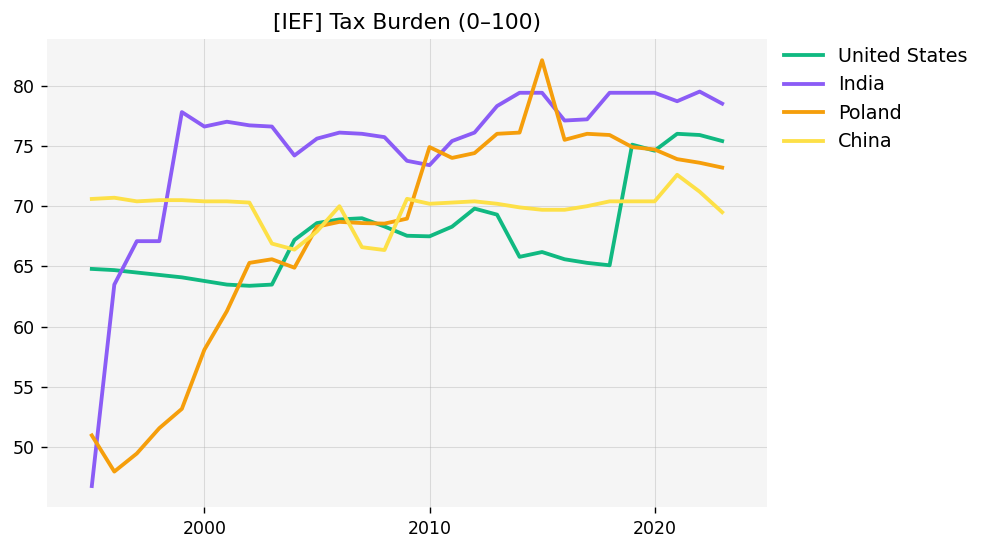

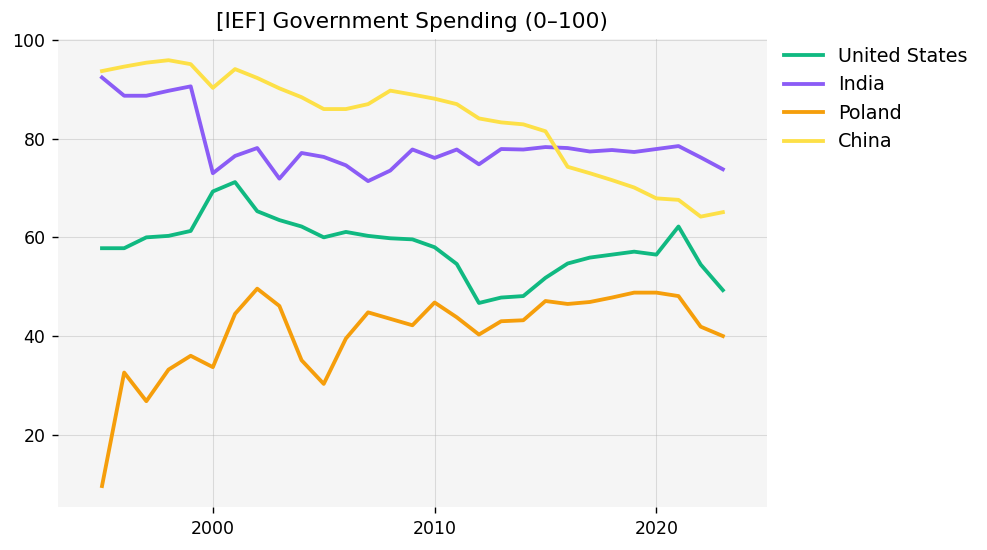

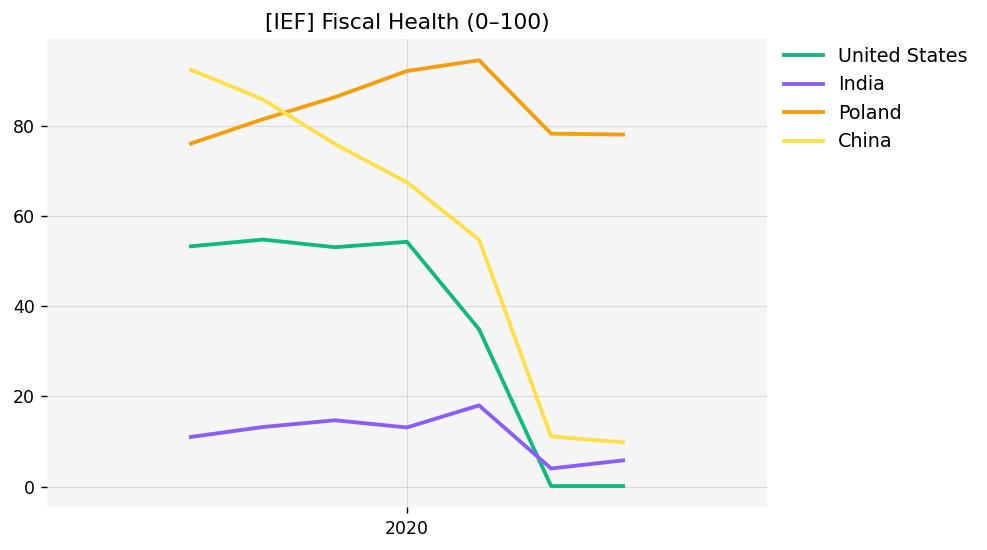

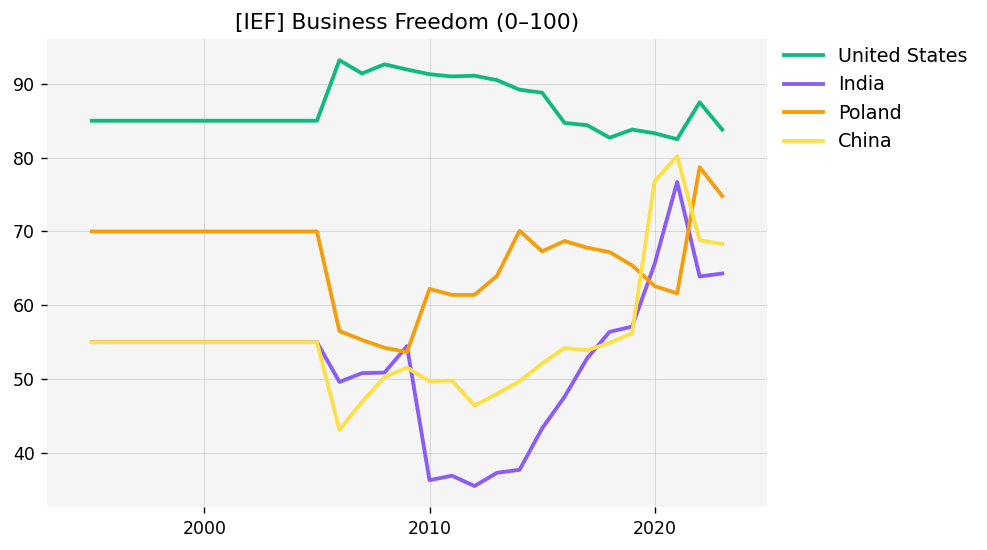

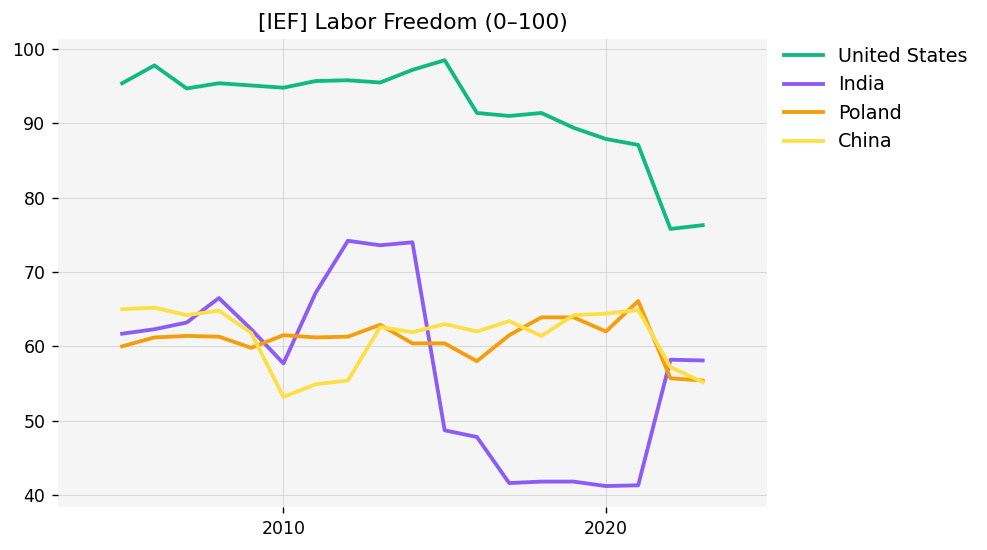

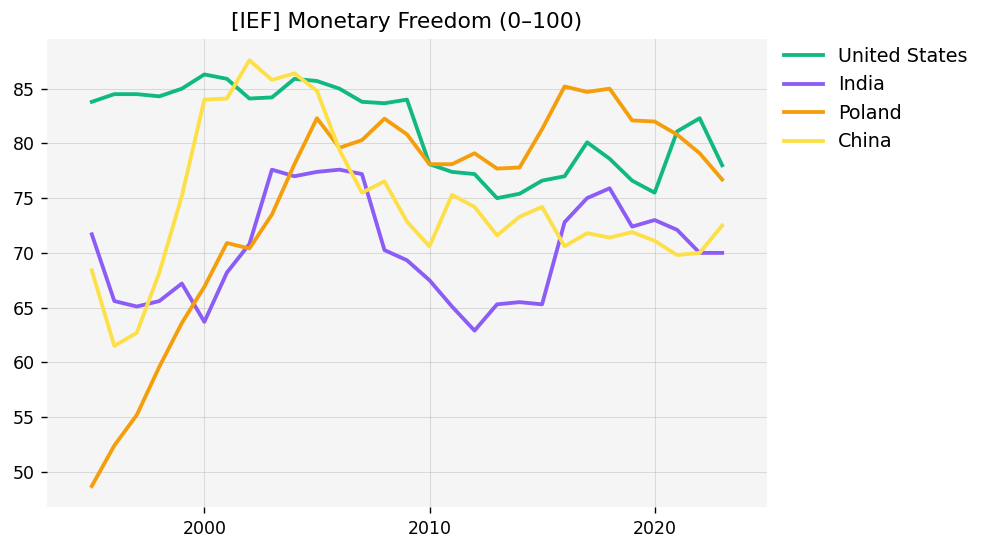

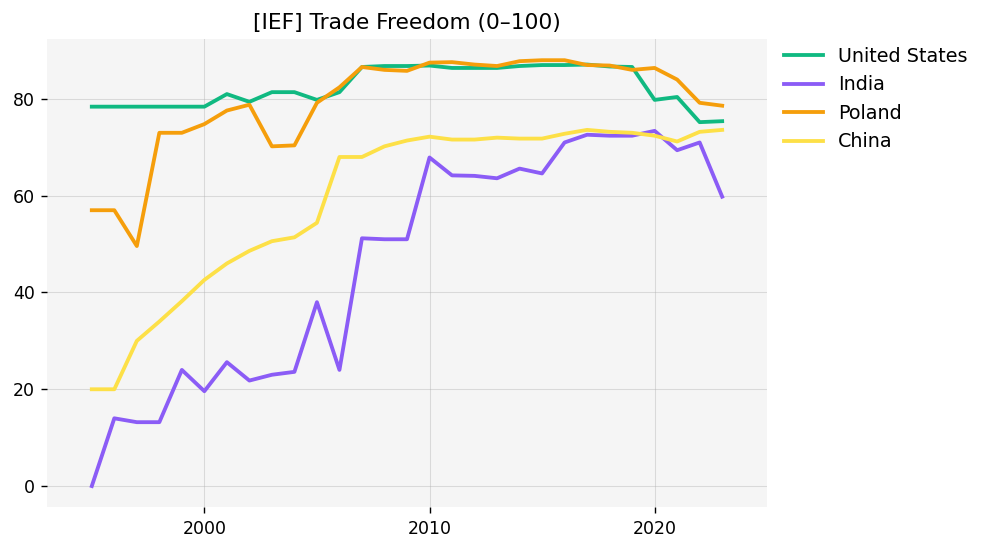

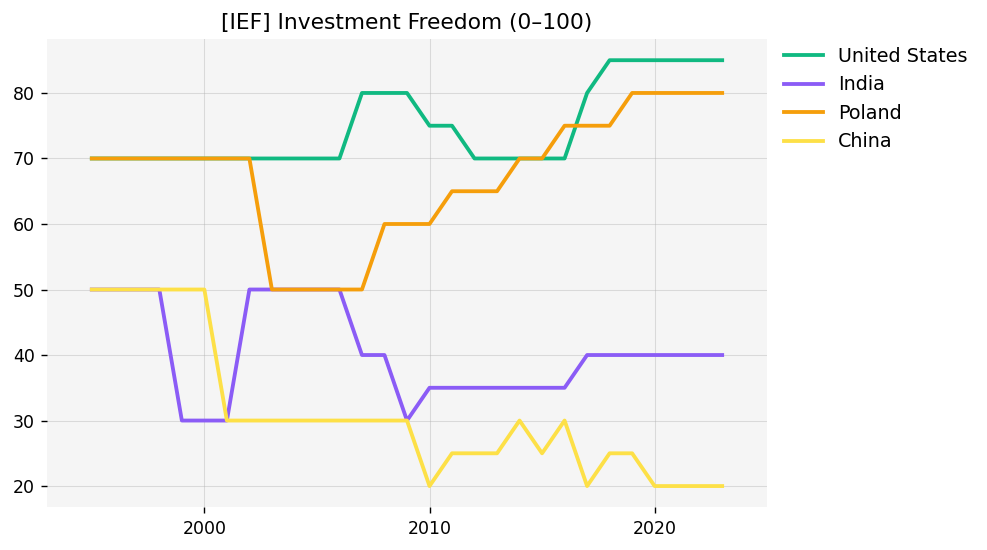

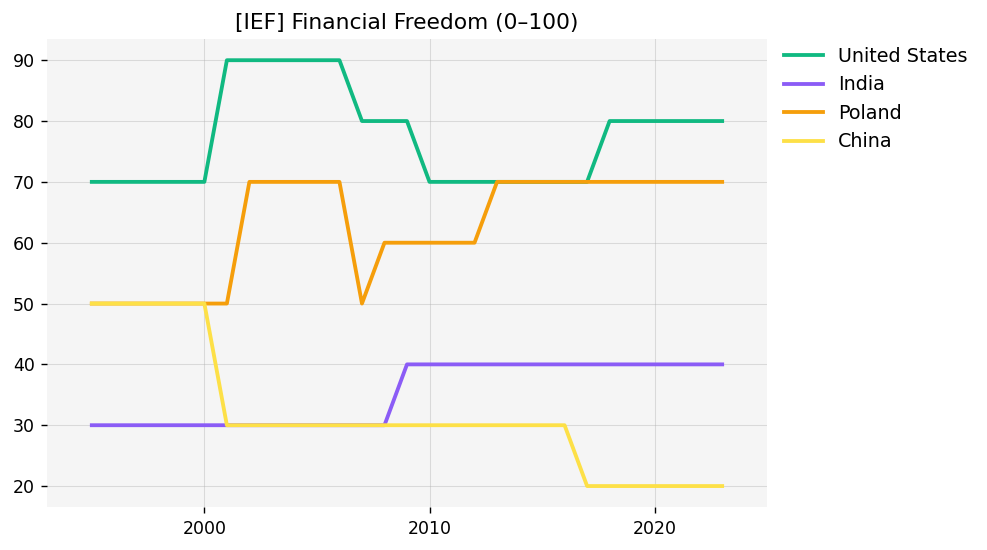

In [ ]:
# timeseries of all vars

from functions.labels import *
from functions.plot import vars_timeseries

countries = ["United States", "India", "Poland", "China"]
colors = ["#10b981", "#8b5cf6", "#f59e0b", "#fde047"]

# filter and unfilter labels to view vars timeseries per dataset

labels = [
    fiw_labels,
    # efw_labels,
    ief_labels,
    # p5d_labels,
    # pts_labels,
    # wgi_labels,
    # wb_iq_labels,
    # controls_labels
]

for label in labels:
    vars_timeseries(df, label, countries, colors)

## Target

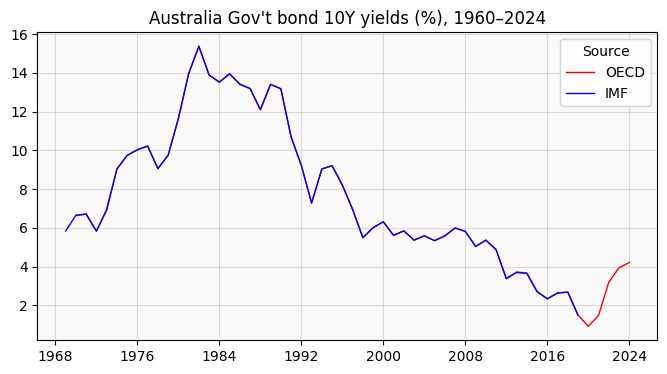

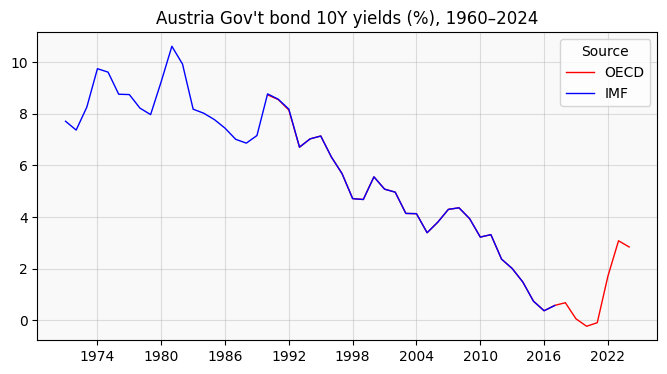

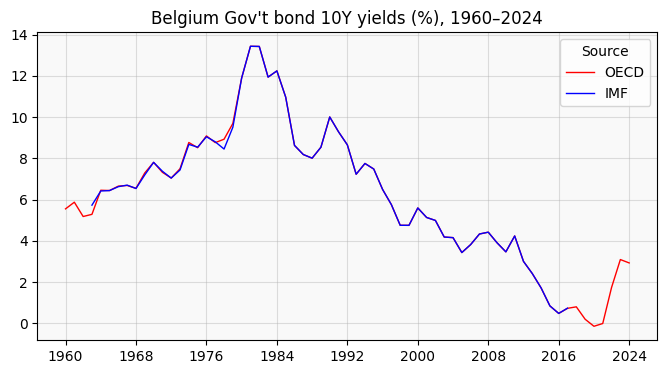

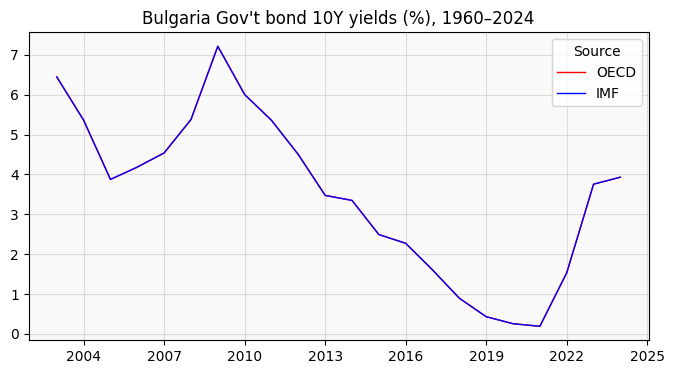

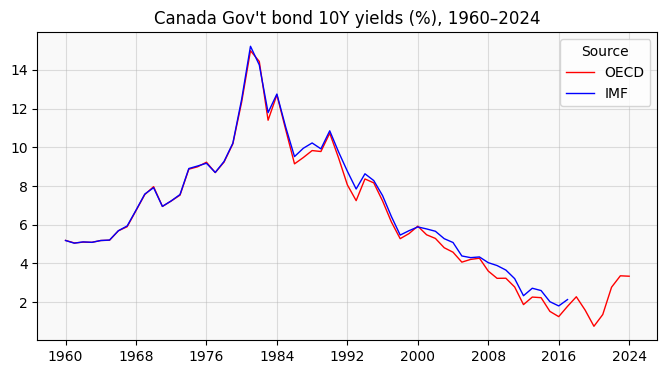

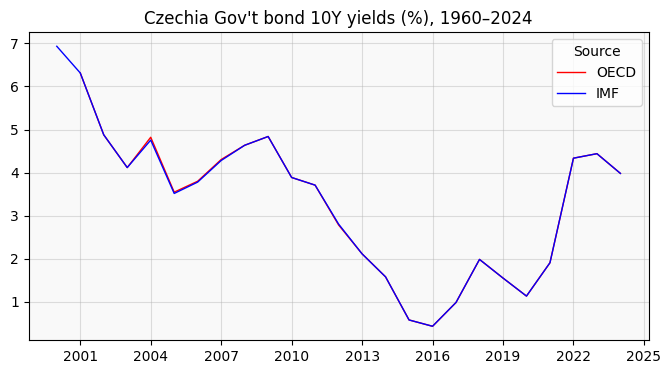

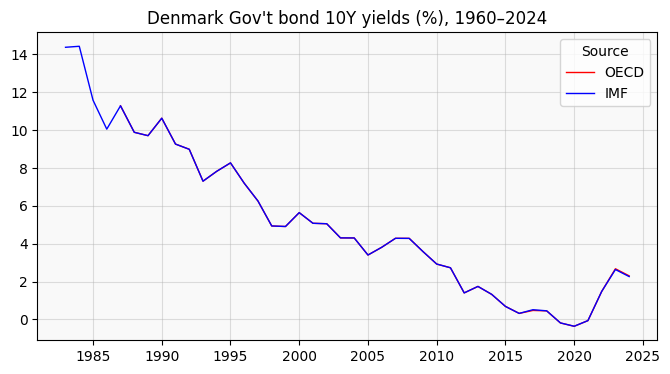

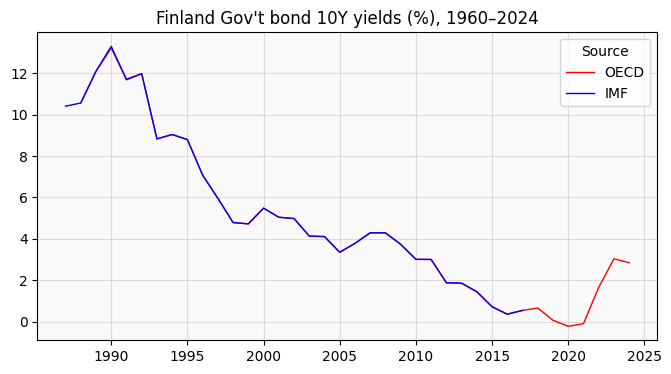

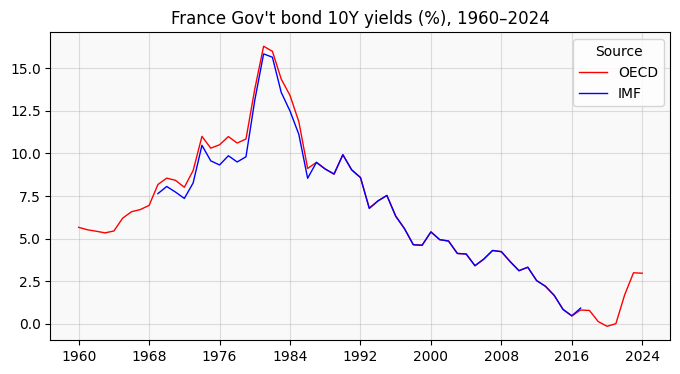

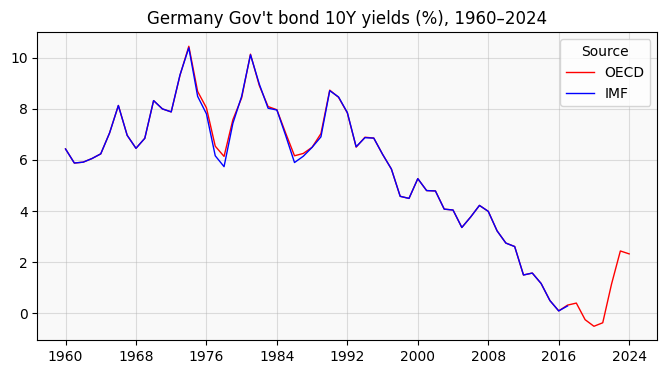

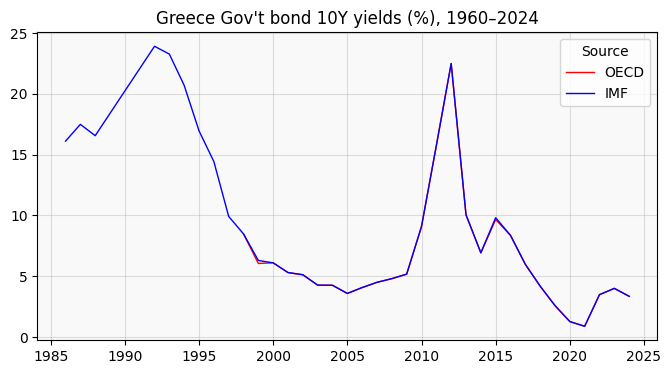

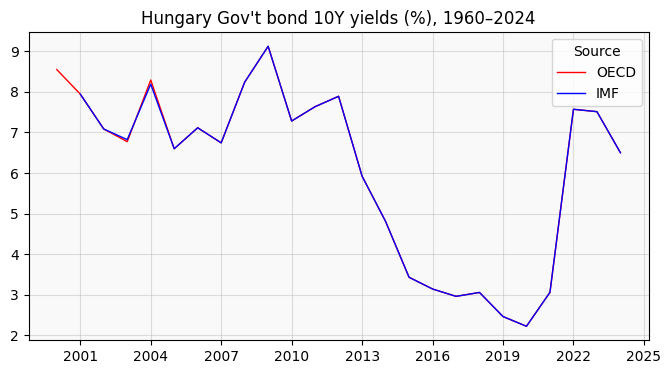

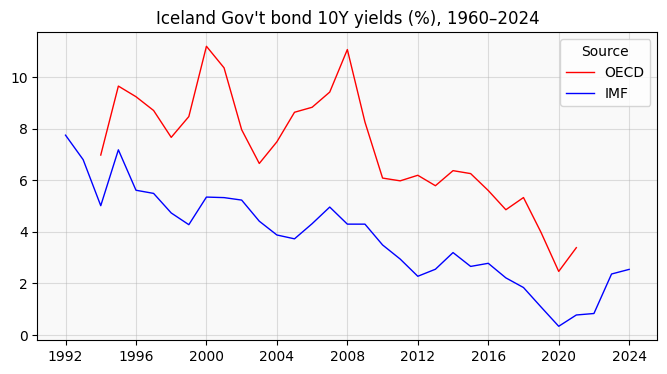

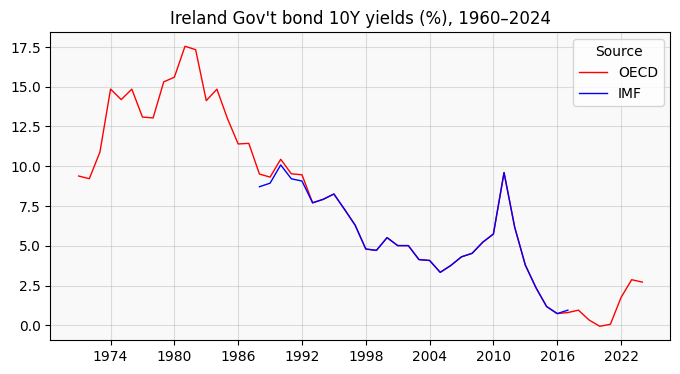

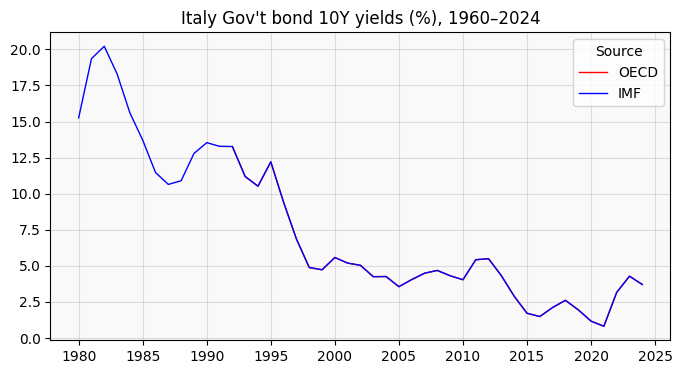

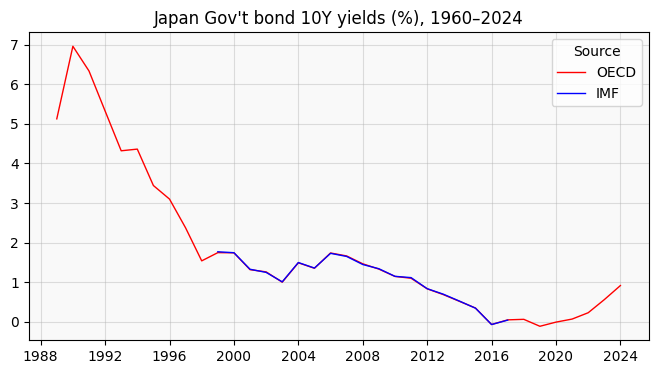

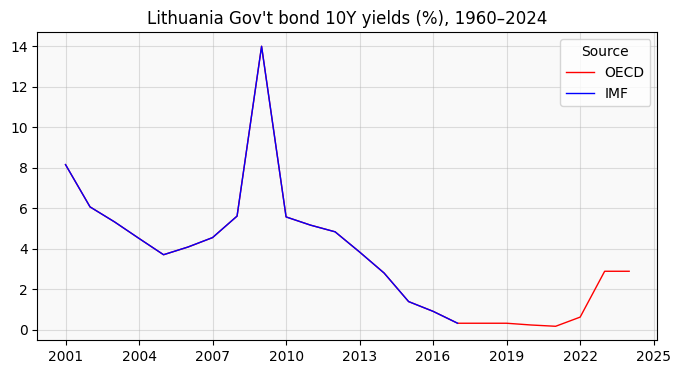

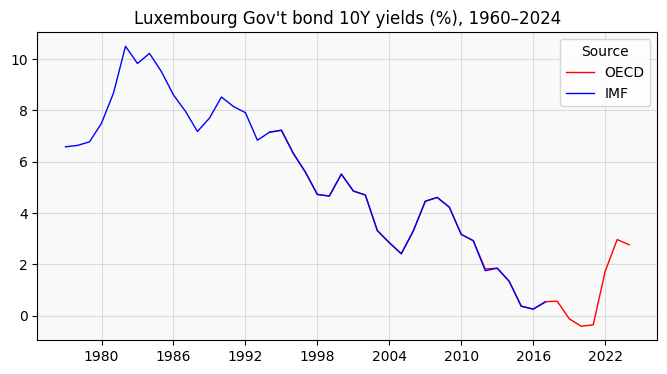

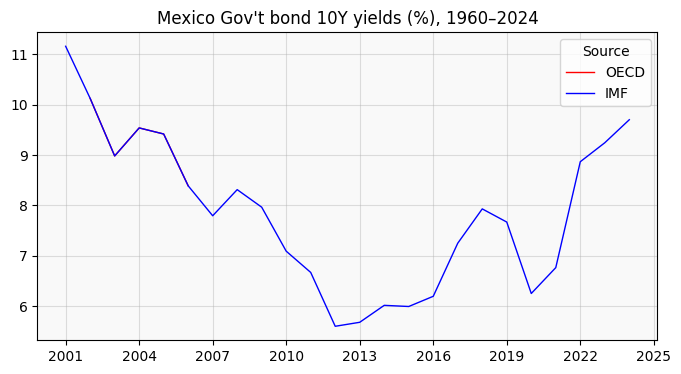

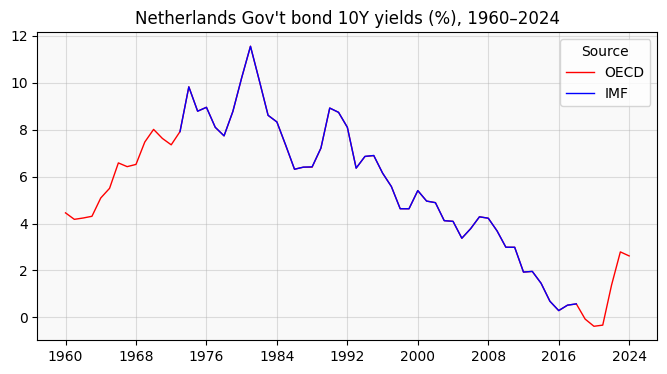

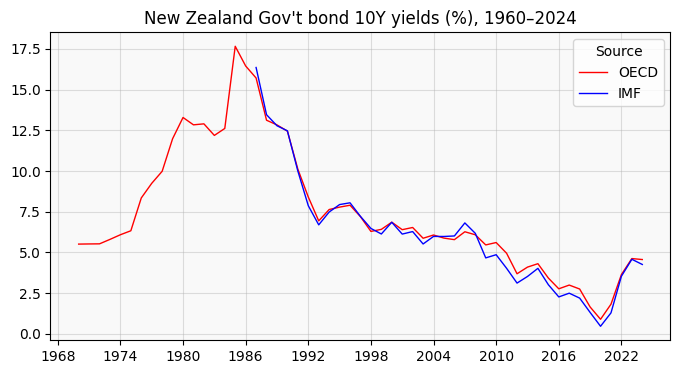

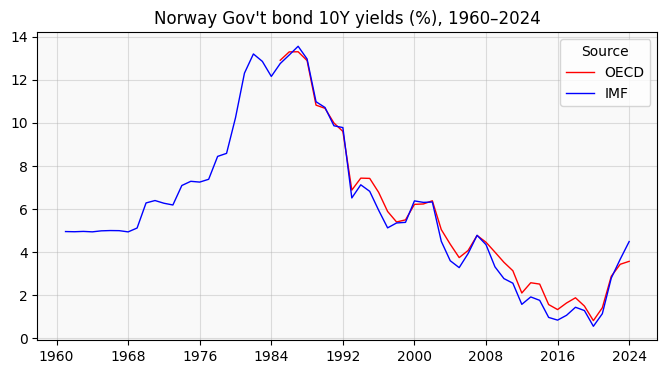

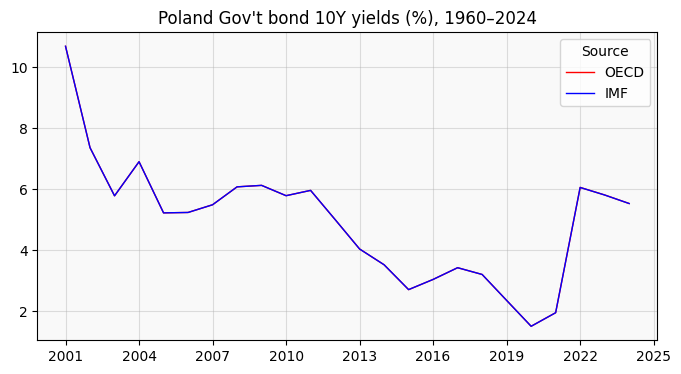

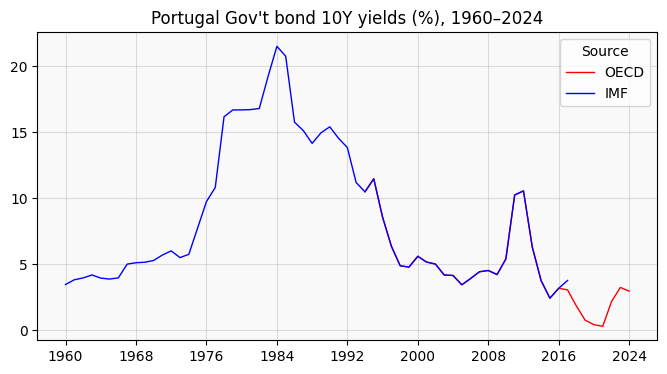

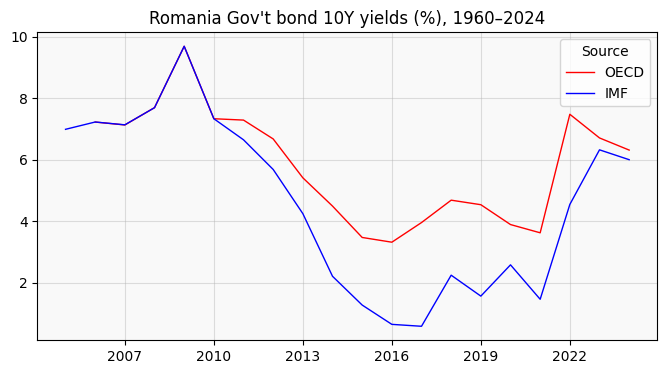

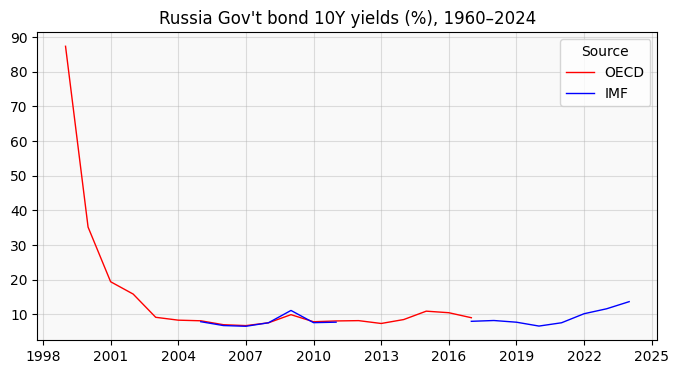

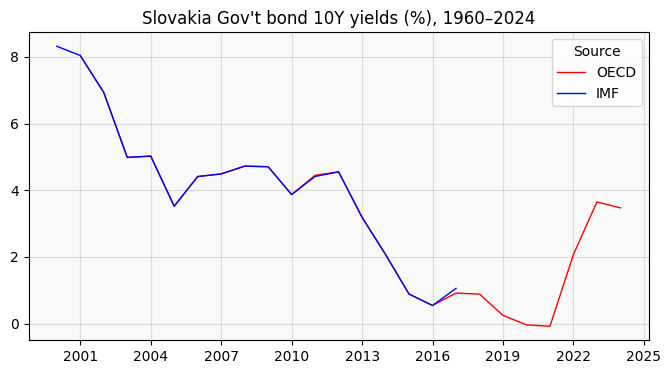

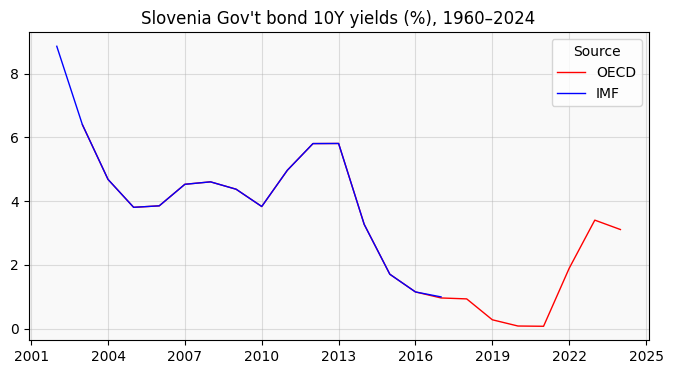

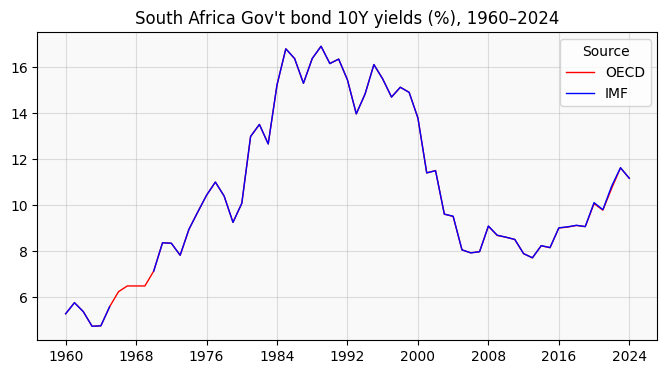

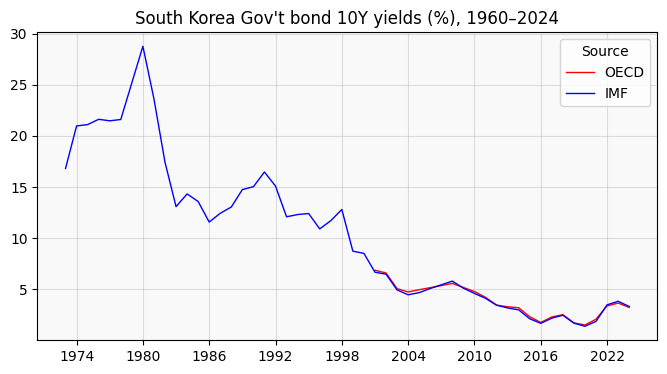

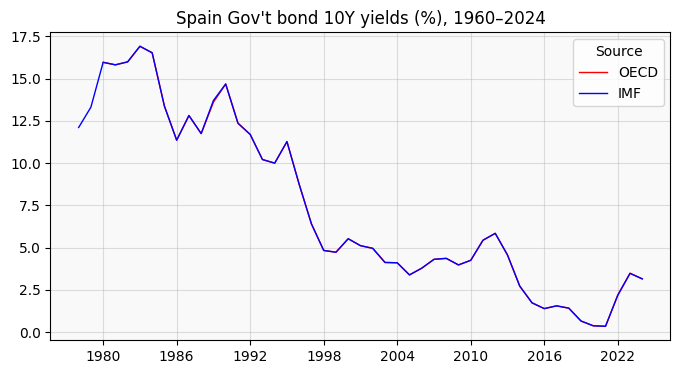

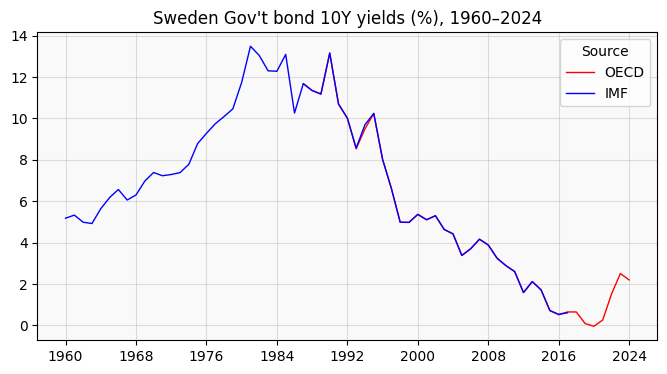

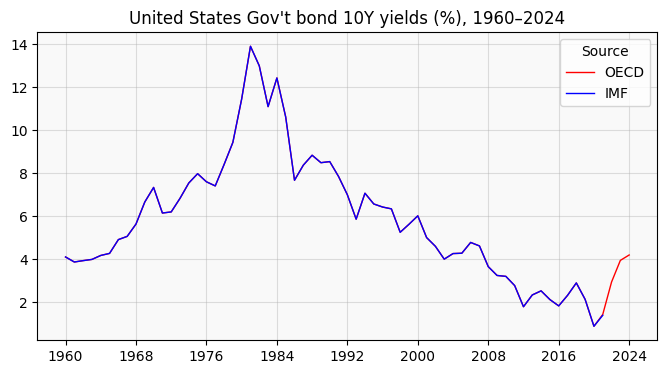

In [ ]:
# view alignment of 10Y yield sources

# pip install sdmx1
import sdmx
import country_converter as coco
from functions.load import load_target
from functions.plot import compare_target_sources

tgt = load_target("files/OECD.csv", merge_sources=False)
compare_target_sources(tgt, 'both') # view countries were both sources are present

# target yield is composed of OECD (preferred) and IMF data

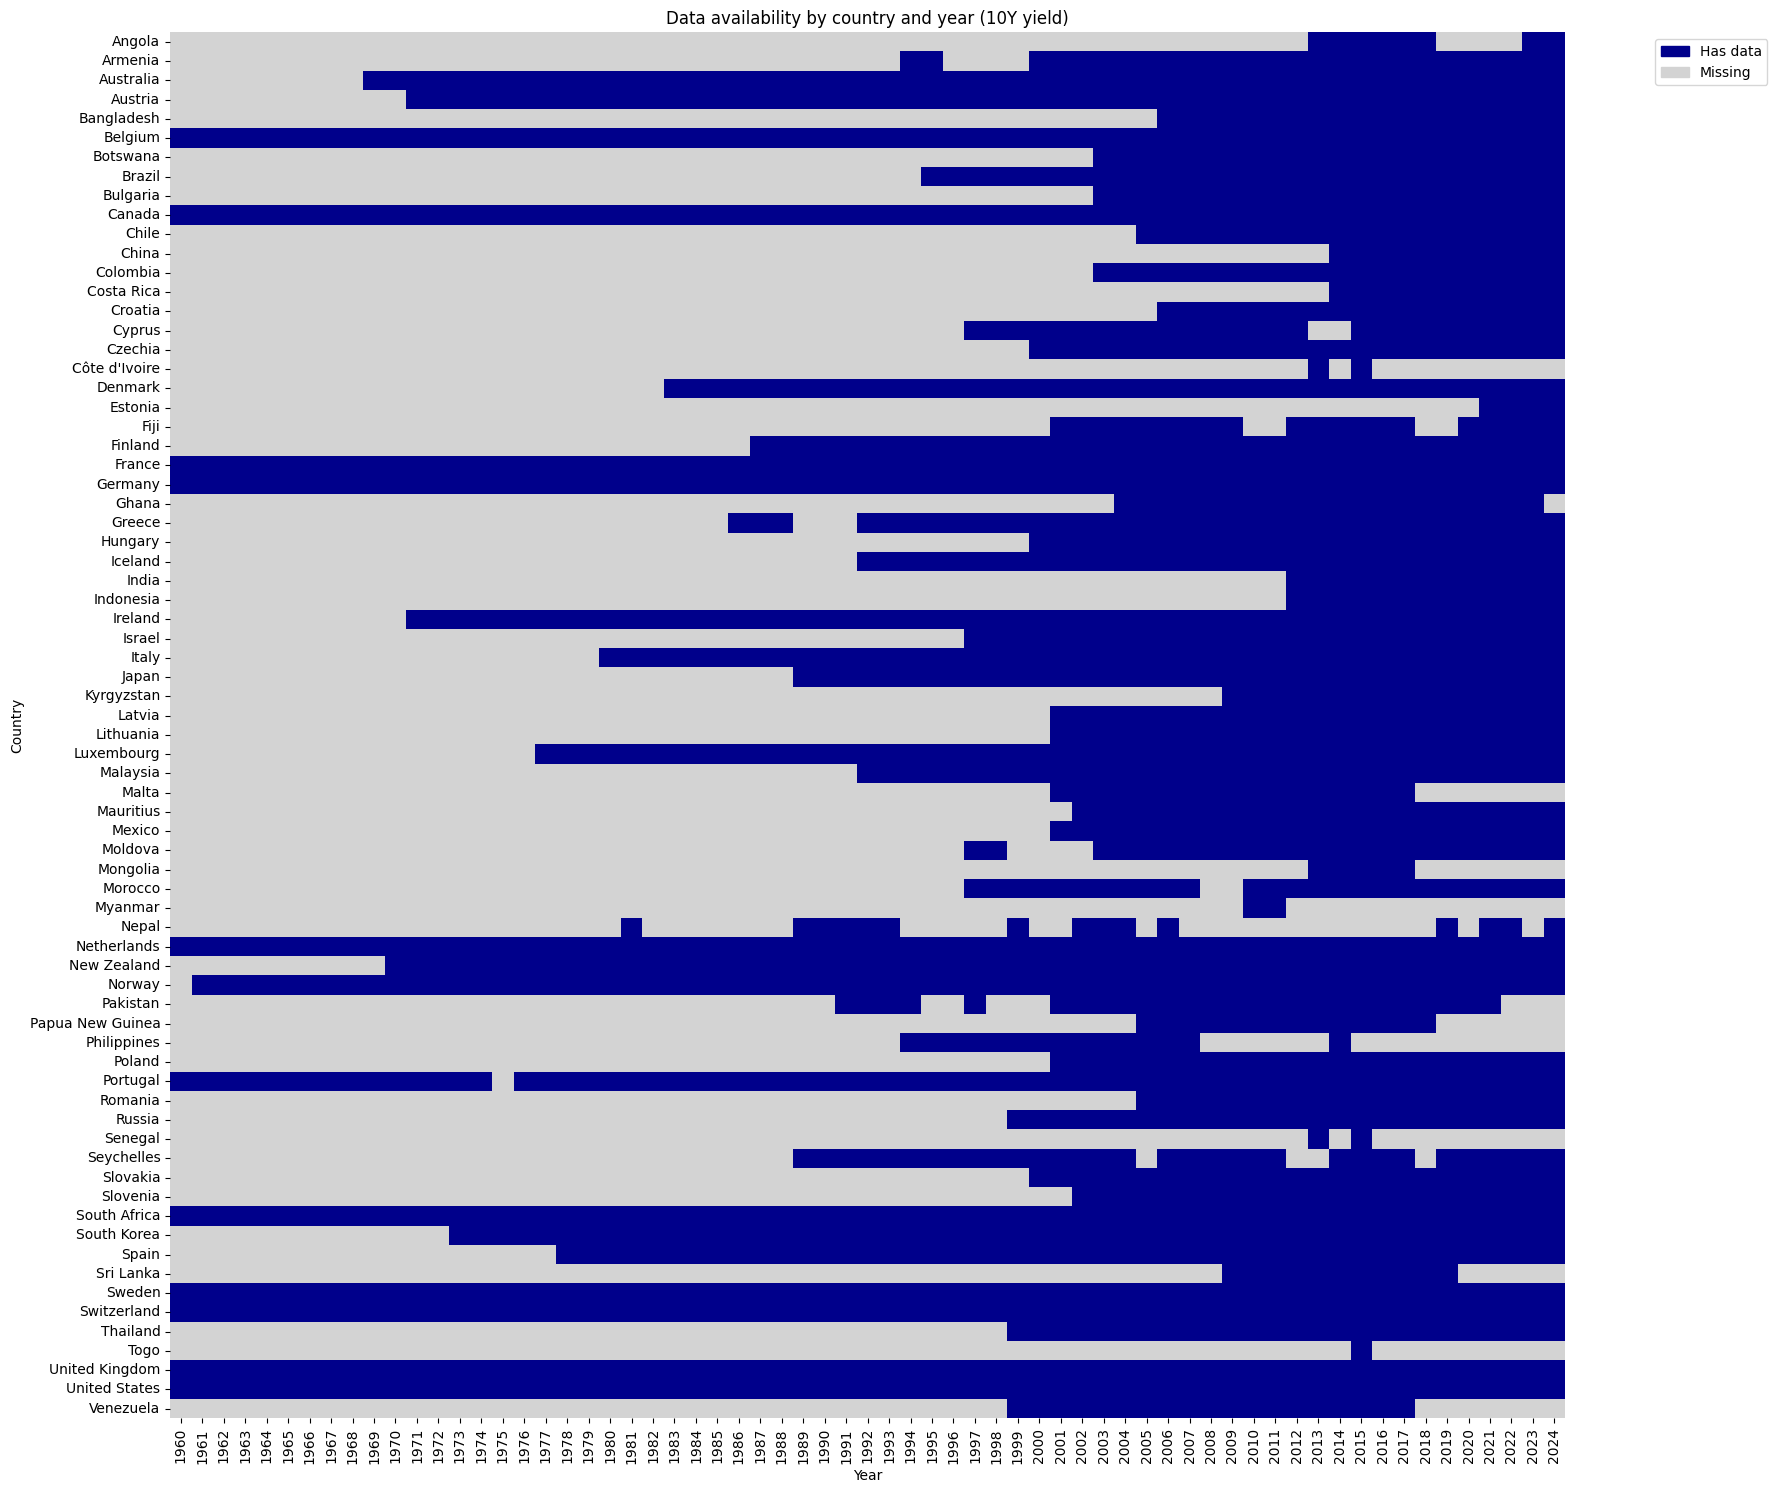

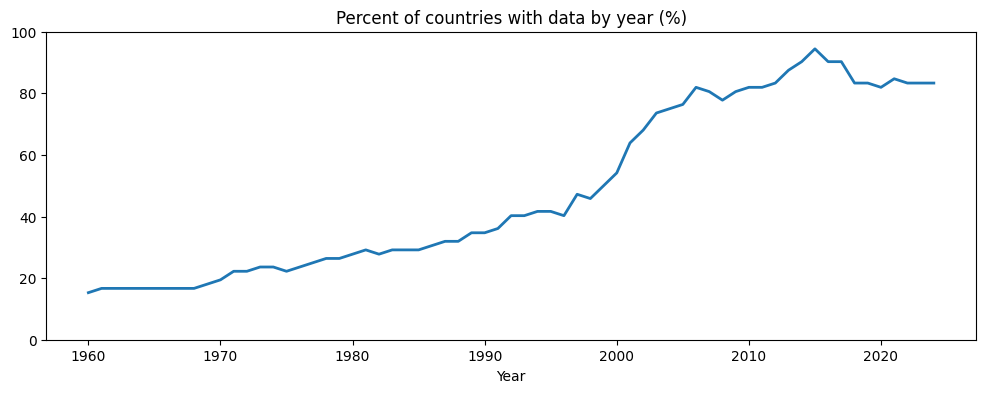

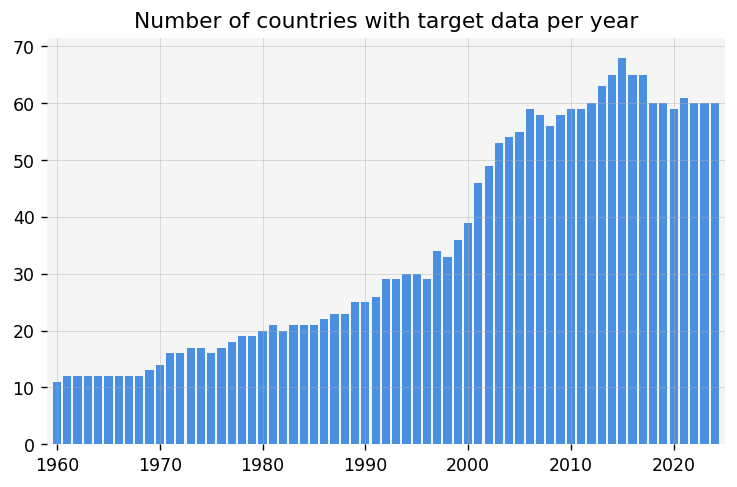

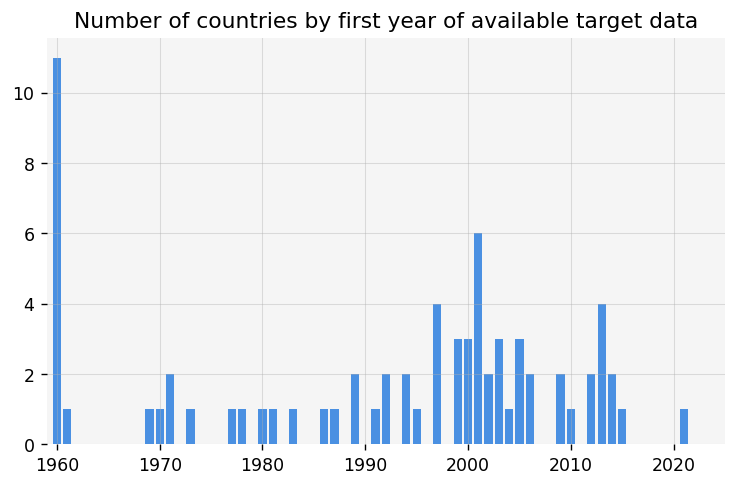

In [ ]:
# target coverage

from functions.plot import target_coverage, target_coverage_start

target_coverage(df, excl_missing=True) # excl missing countries
target_coverage_start(df, cumulative=True)
target_coverage_start(df, cumulative=False)

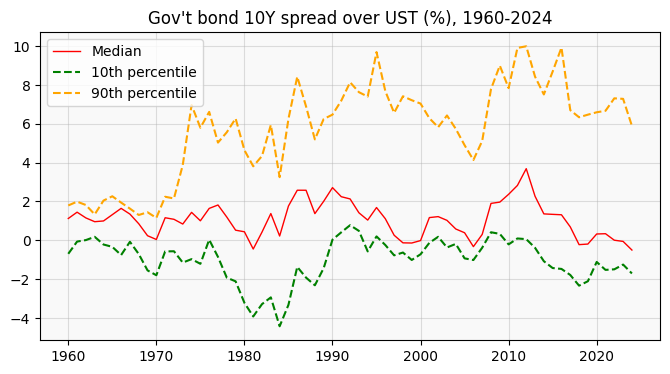

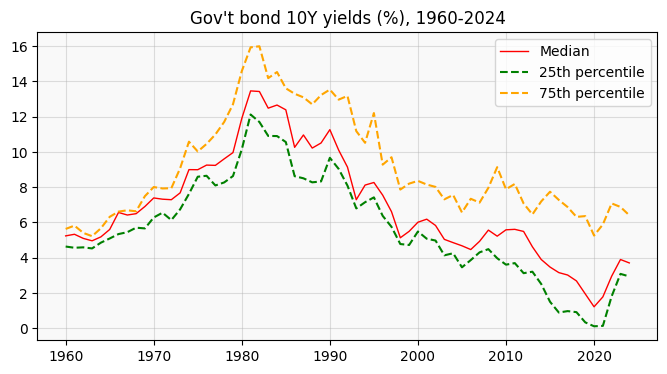

In [ ]:
# check timeseries of chosen spread / yield percentiles

from functions.utils import prep_target

df = prep_target(df)

from functions.plot import target_timeseries

target_timeseries(df, 'spread', 0.1, 0.9)
target_timeseries(df, 'yield', 0.25, 0.75)

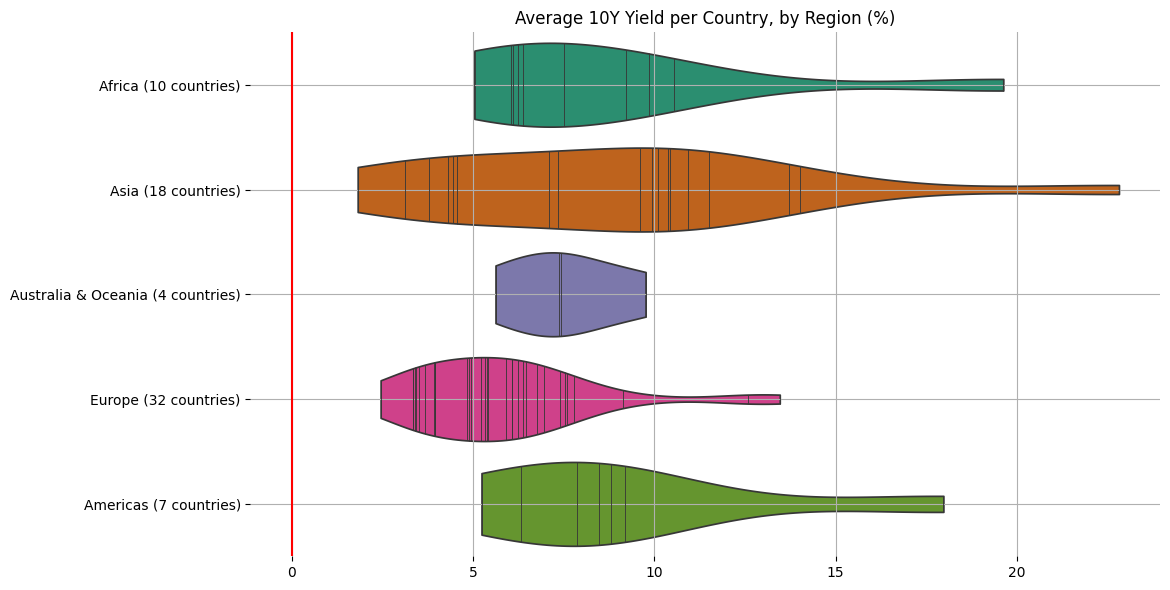

In [ ]:
# violin plot of country average yields per region

from functions.plot import region_violin

region_violin(df)

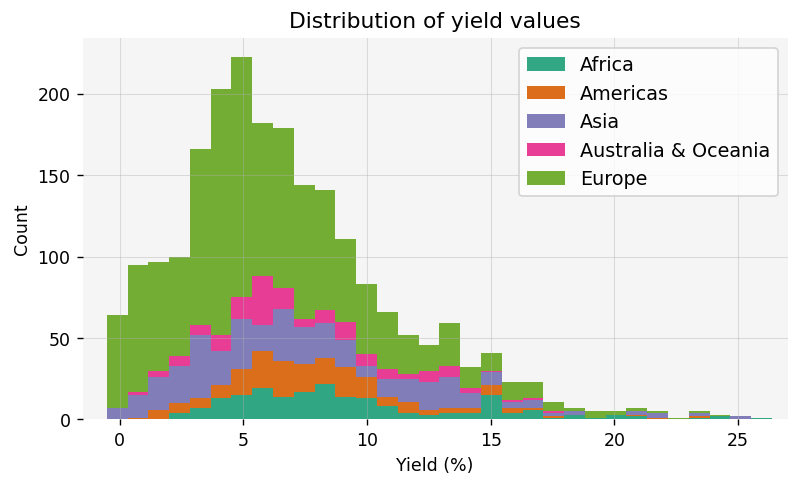

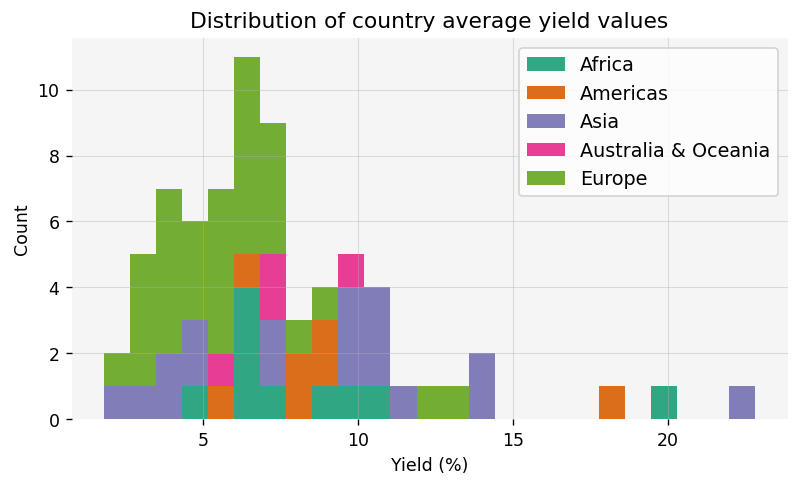

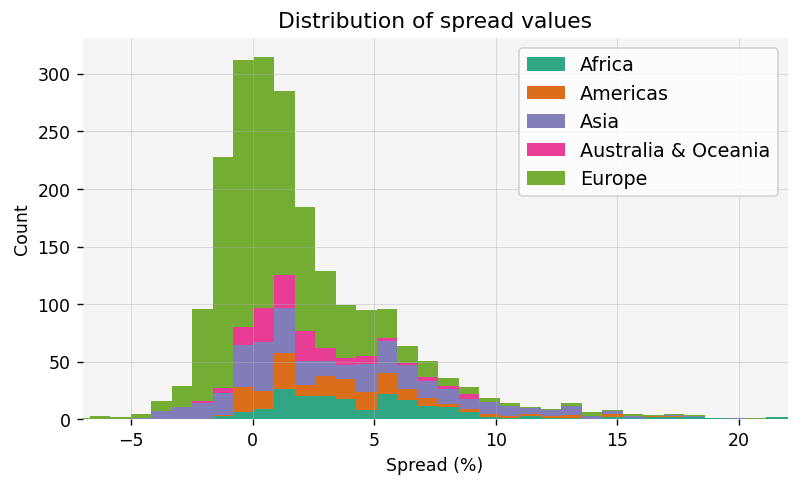

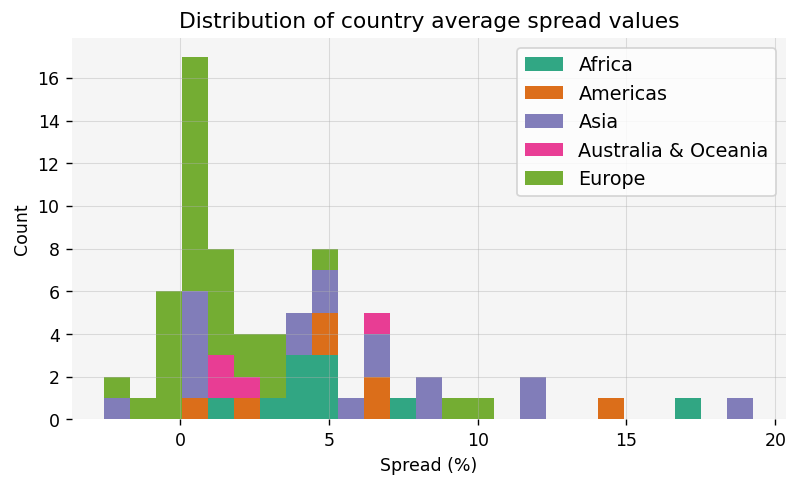

In [ ]:
# histogram of yield / spread values

from functions.plot import target_histogram

target_histogram(df, variable="tgt_yield", country_average=False)
target_histogram(df, variable="tgt_yield", country_average=True)
target_histogram(df, variable="tgt_spread", country_average=False)
target_histogram(df, variable="tgt_spread", country_average=True)

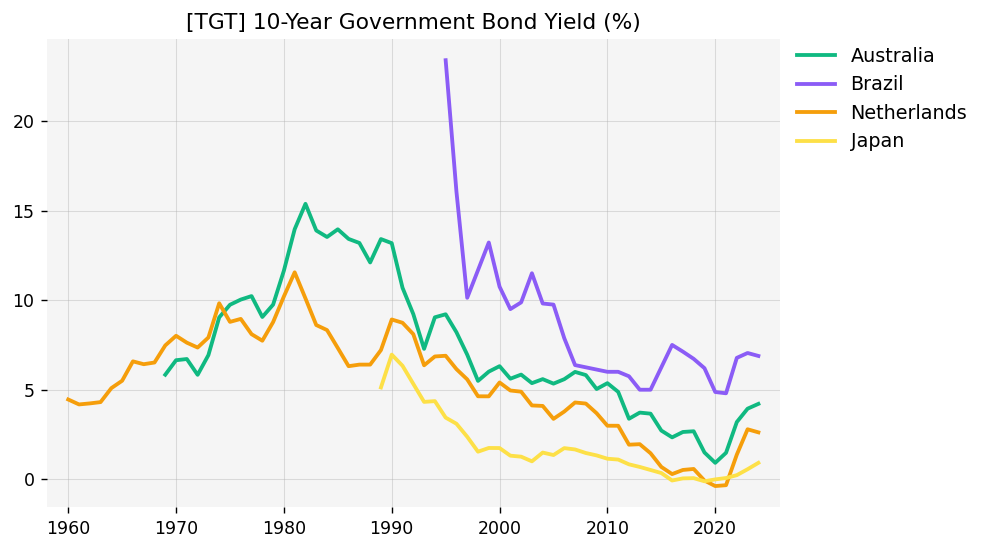

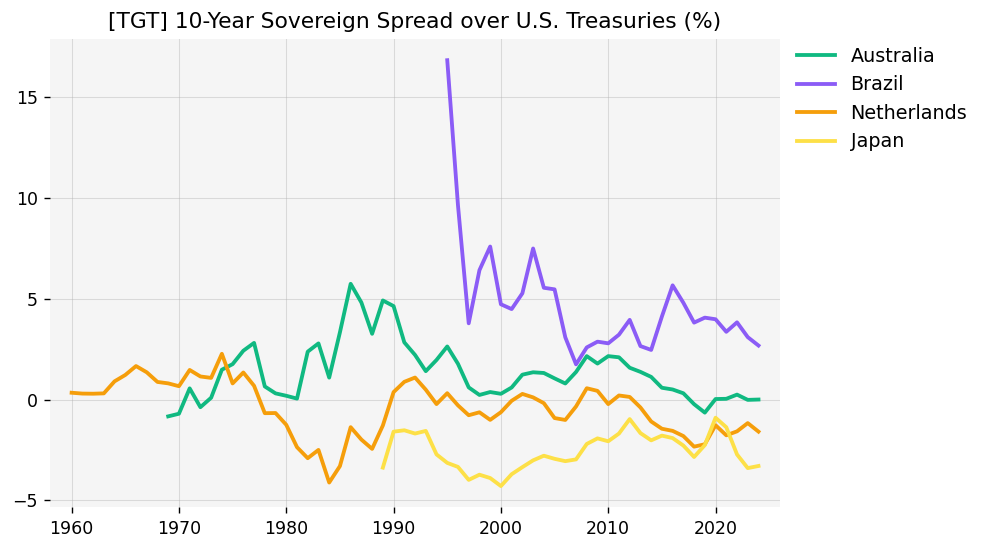

In [ ]:
# target timeseries

from functions.labels import tgt_labels
from functions.plot import vars_timeseries

countries = ["Australia", "Brazil", "Netherlands", "Japan"]
colors = ["#10b981", "#8b5cf6", "#f59e0b", "#fde047"]

vars_timeseries(df, tgt_labels, countries, colors)

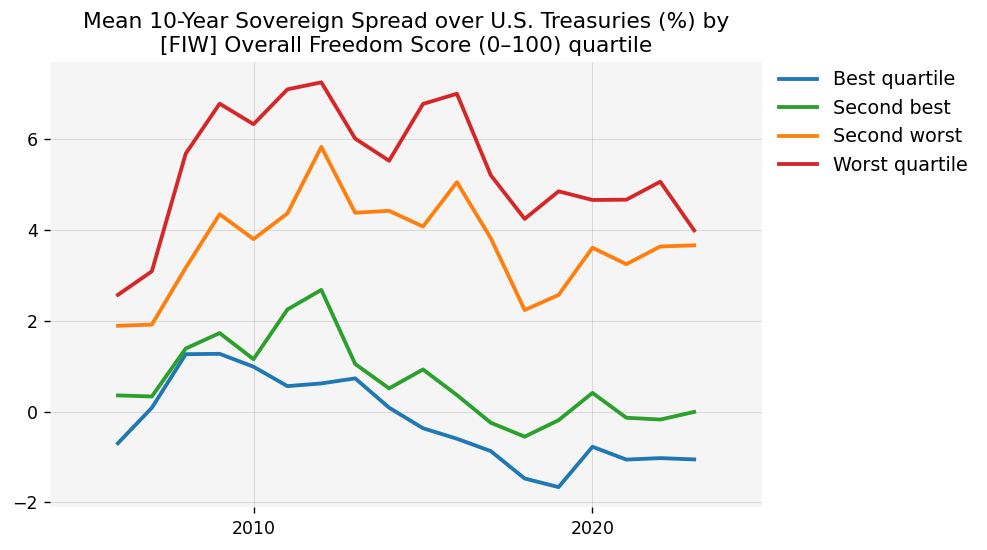

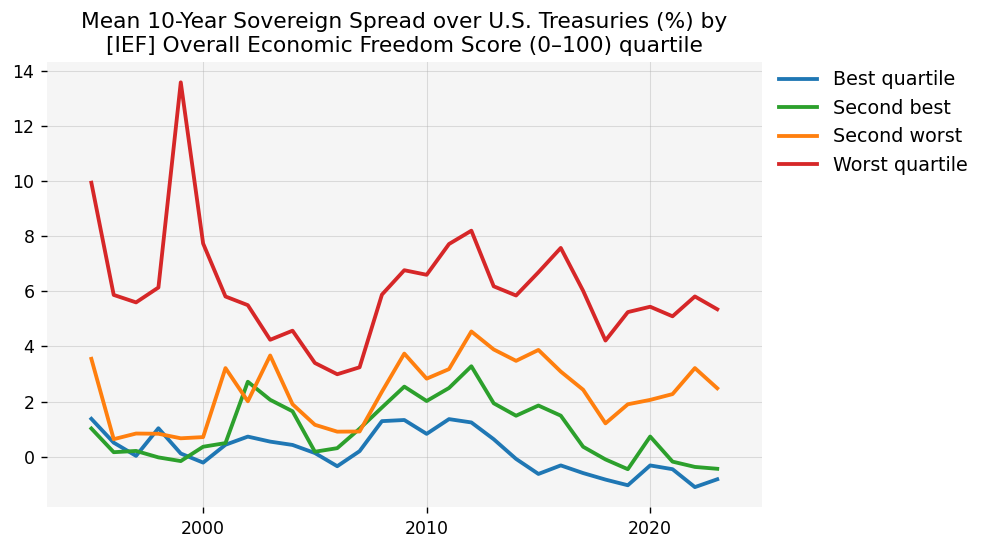

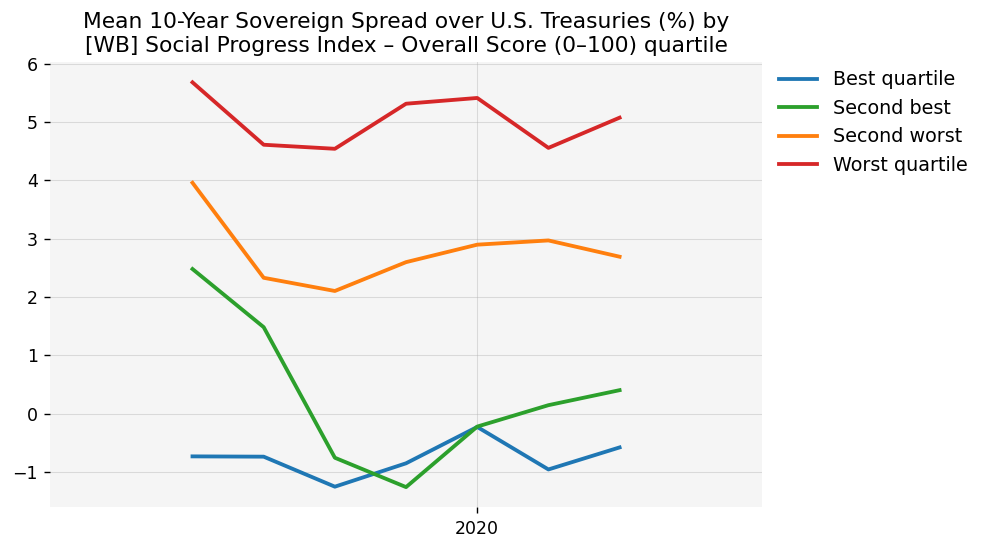

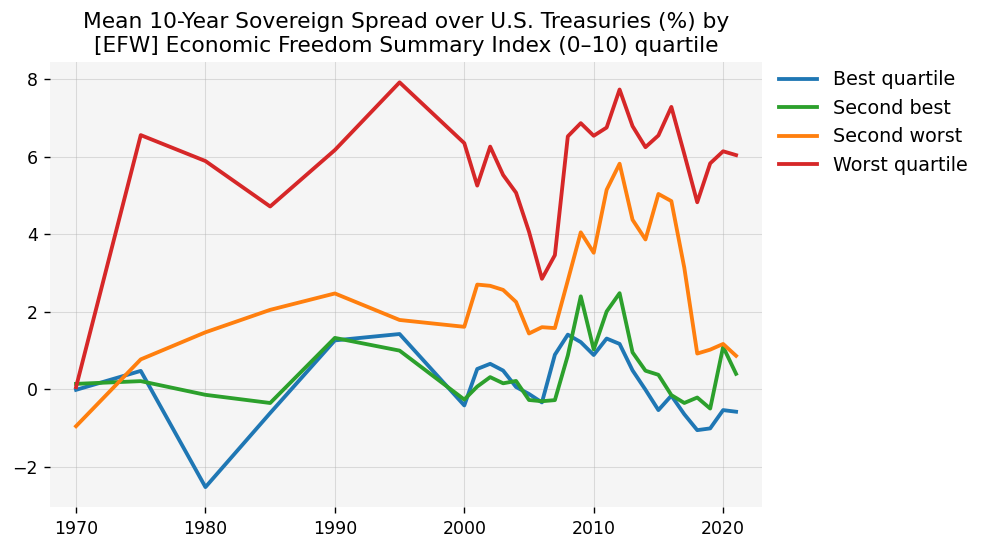

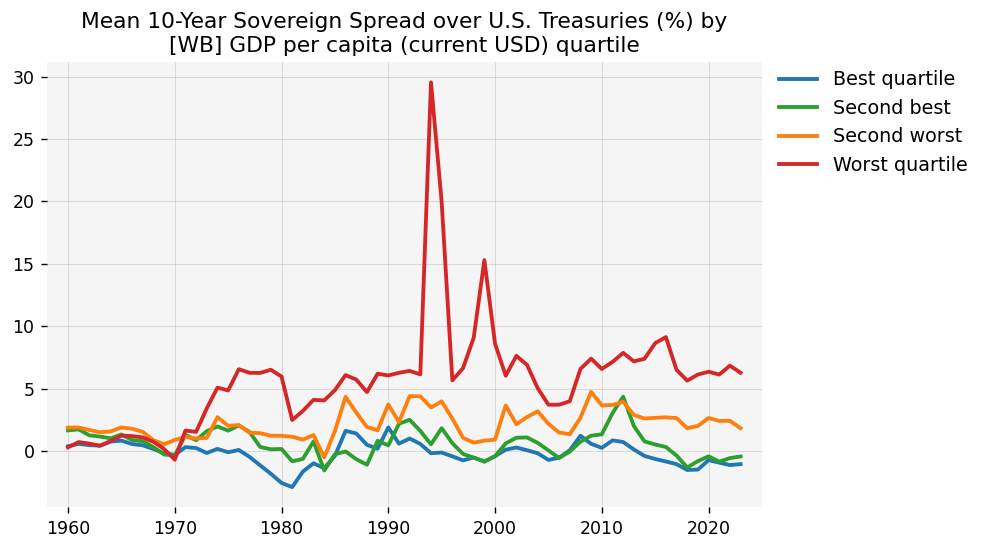

In [ ]:
# target per (IQ / macro) variable quartiles

from functions.plot import target_timeseries_per_var_quartile

# picking overall scores

totals = {
        "fiw_total": "Overall Freedom Score (0–100)",
        "ief_overall_score": "Overall Economic Freedom Score (0–100)",
        "wb_iq_spi_ovrl": "Social Progress Index – Overall Score (0–100)",
        "efw_economic_freedom_summary_index": "Economic Freedom Summary Index (0–10)",
        "wb_ny_gdp_pcap_cd": "GDP per capita (current USD)",
}

target_timeseries_per_var_quartile(df, target_col="tgt_spread", totals=totals)

## Correlations

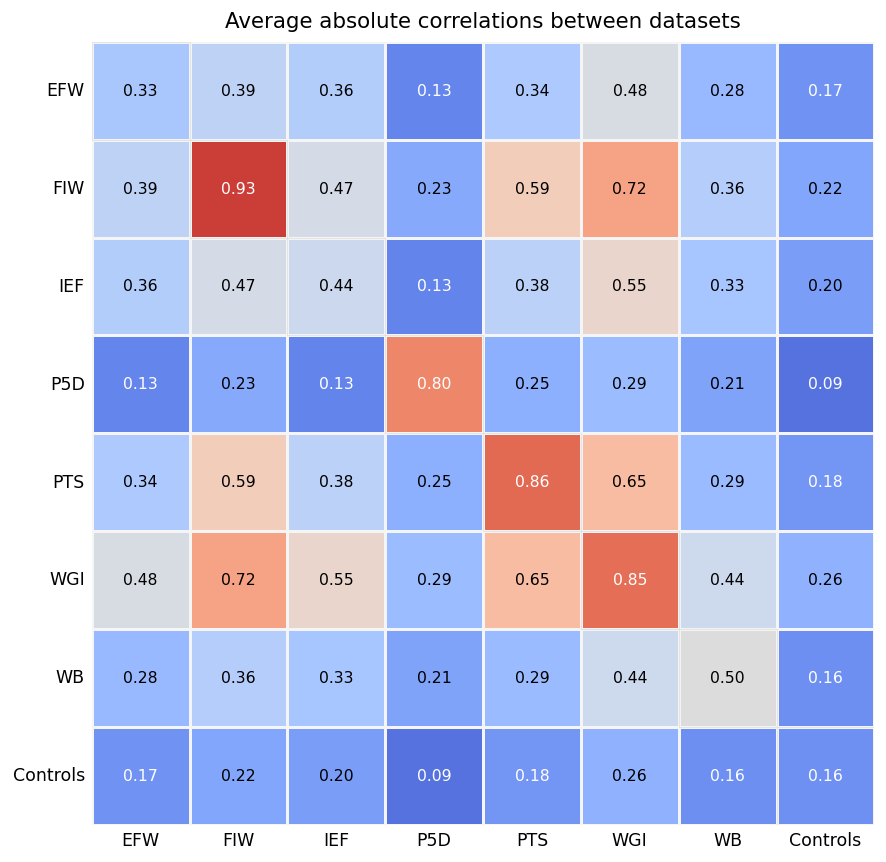

In [ ]:
# correlation heatmap by dataset

from functions.labels import *

label_dicts = {
    "efw": efw_labels,
    "fiw": fiw_labels,
    "ief": ief_labels,
    "p5d": p5d_labels,
    "pts": pts_labels,
    "wgi": wgi_labels,
    "wb": wb_iq_labels,
    "controls": controls_labels,
    # "tgt": tgt_labels
}

from functions.plot import correlation_across_datasets

M = correlation_across_datasets(df, label_dicts)

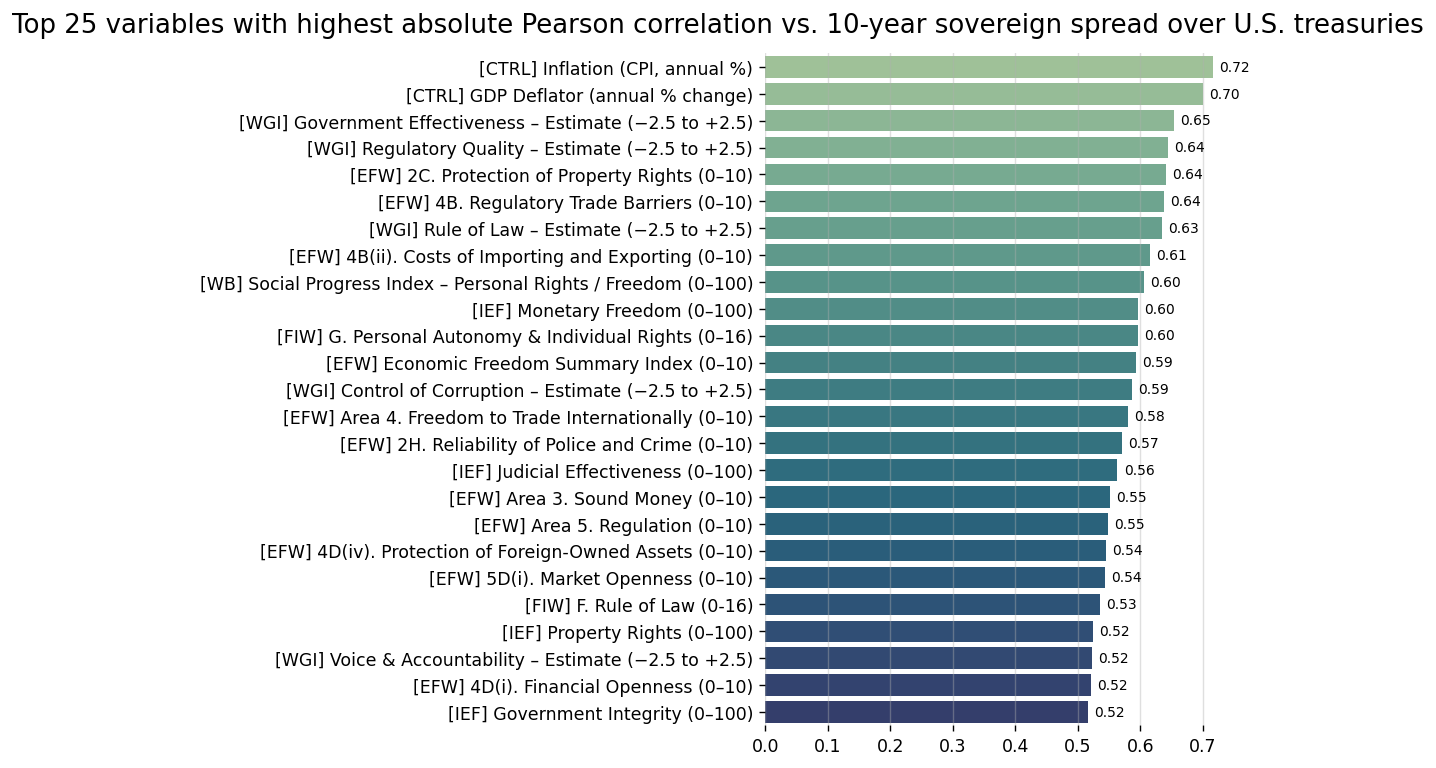

In [ ]:
# top variables correlated with target

from functions.labels import *

label_dicts = {
    "efw": efw_labels,
    "fiw": fiw_labels,
    "ief": ief_labels,
    "p5d": p5d_labels,
    "pts": pts_labels,
    "wgi": wgi_labels,
    "wb": wb_iq_labels,
    "controls": controls_labels,
    # "tgt": tgt_labels
}

from functions.plot import top_correlations

corrs = top_correlations(df, label_dicts, target="tgt_spread", top_n=25)

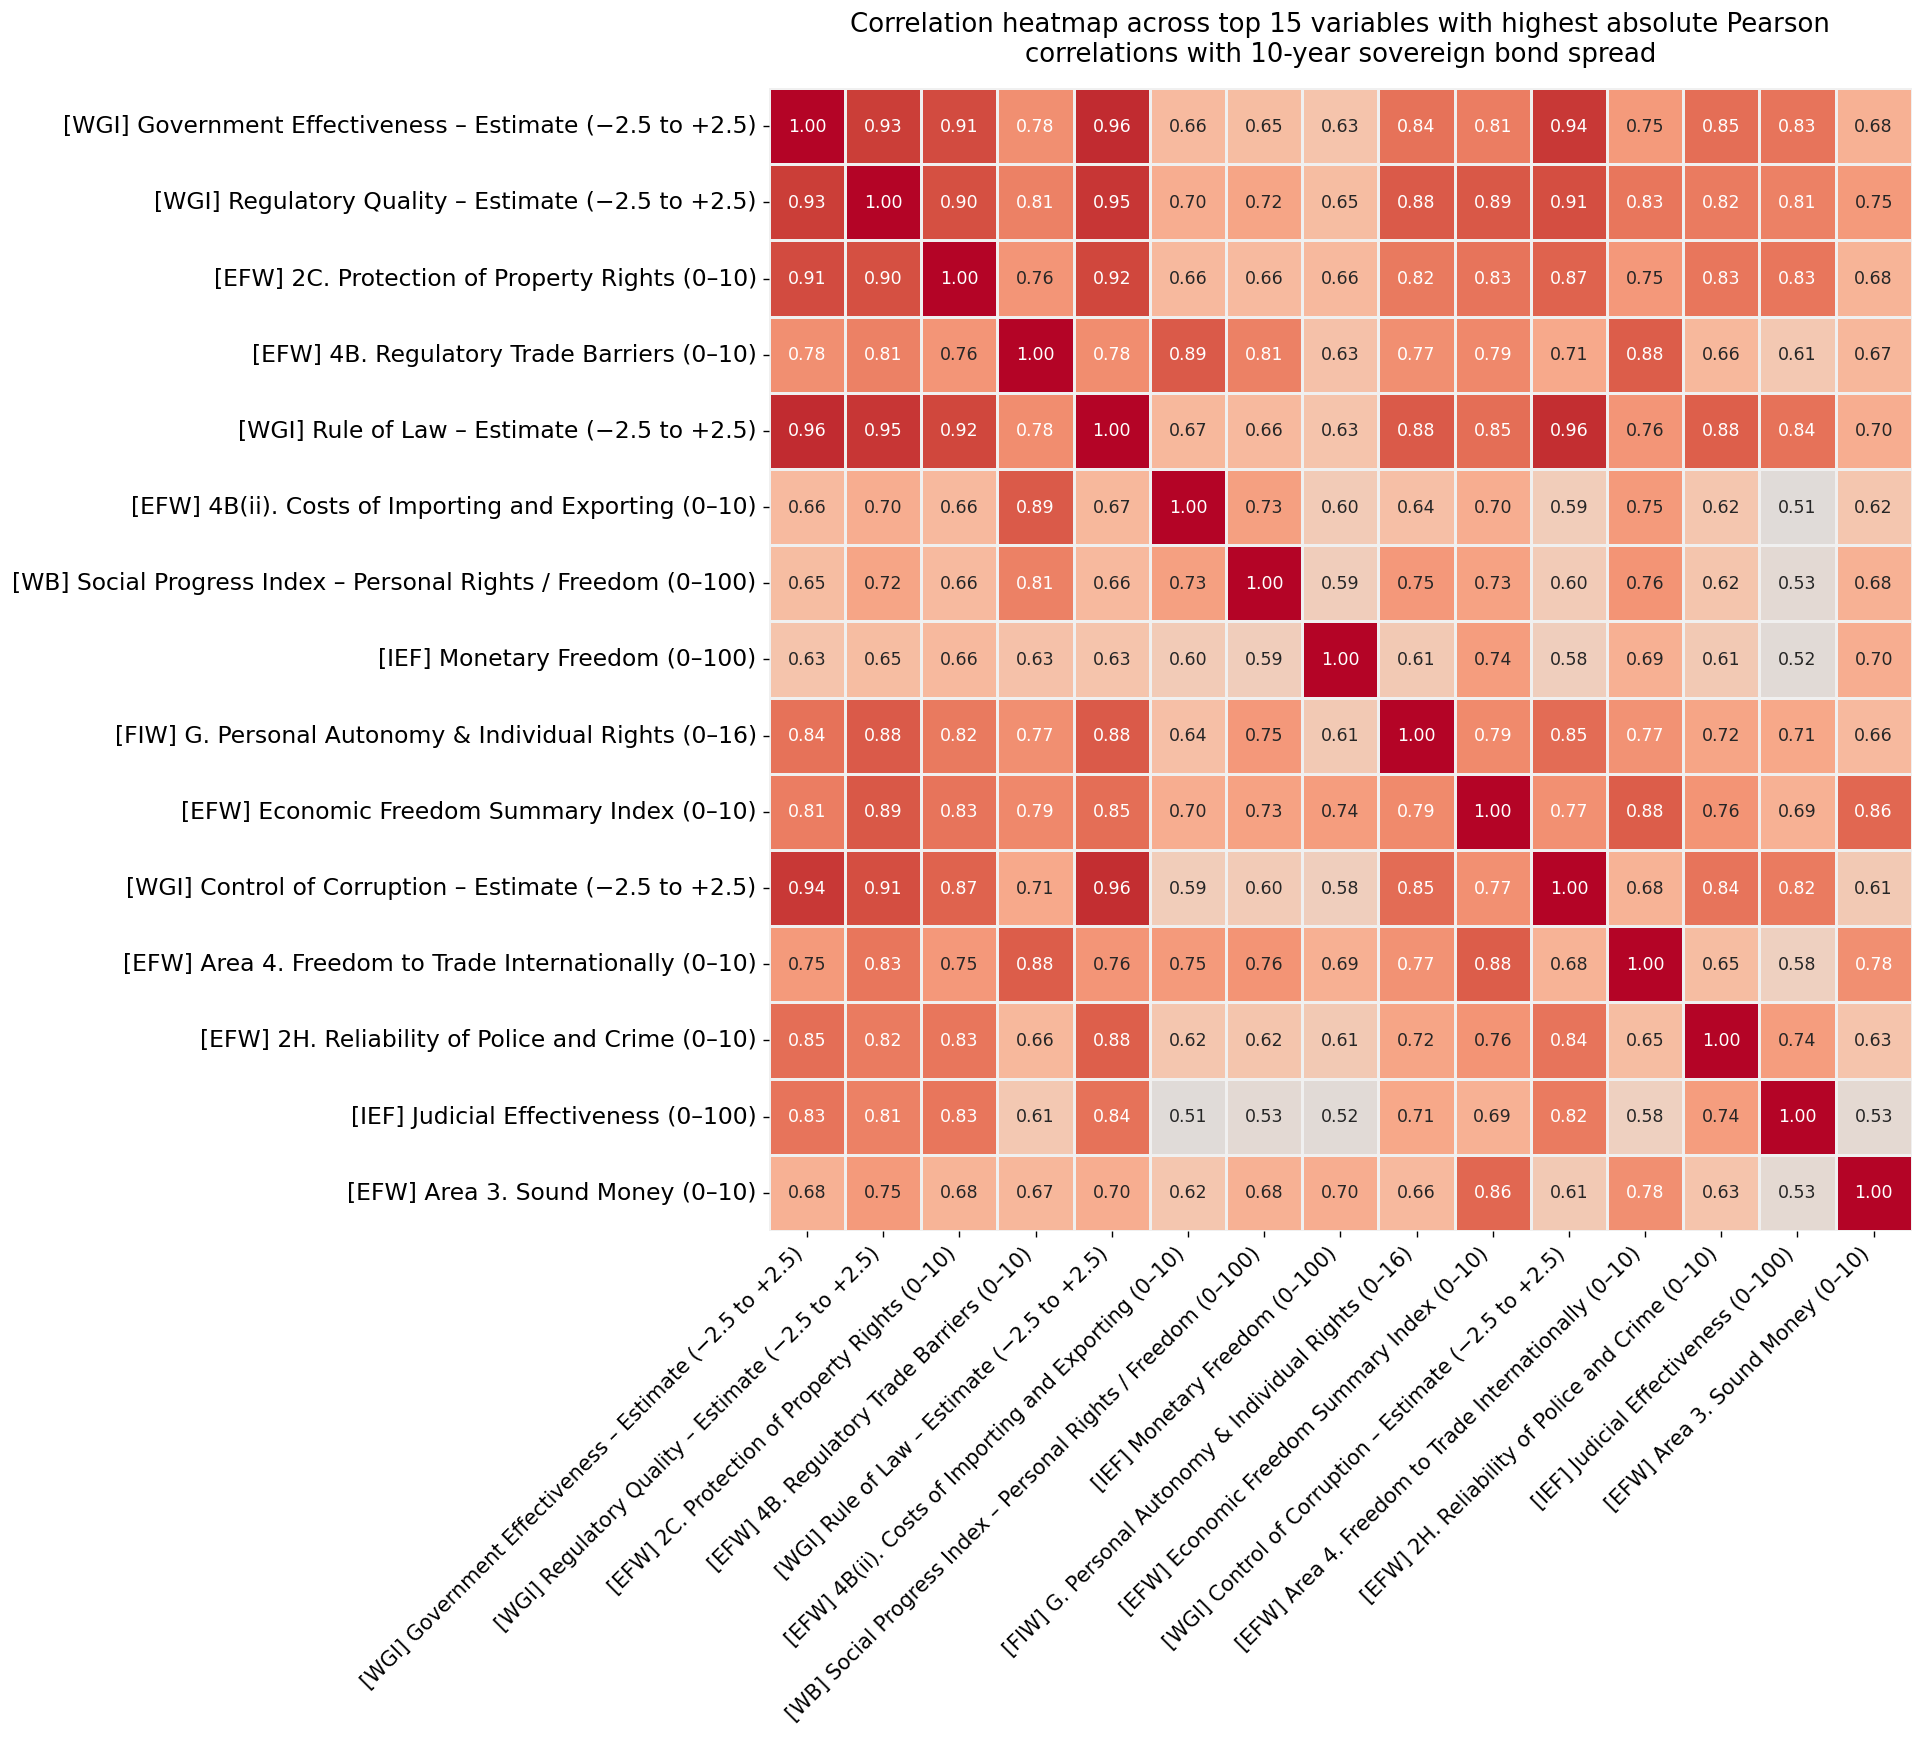

In [ ]:
# correlations across variables most correlated with target

from functions.labels import *

label_dicts={"efw":efw_labels,
             "fiw":fiw_labels,
             "ief":ief_labels,
             "p5d":p5d_labels,
             "pts":pts_labels,
             "wgi":wgi_labels,
             "wb":wb_iq_labels,
             "controls":controls_labels,
             #"tgt":tgt_labels
             }

from functions.plot import correlation_across_top_vars

corr = correlation_across_top_vars(df,
                                   label_dicts,
                                   target="tgt_spread",
                                   top_n=15,
                                   exclude_ctrl=True)

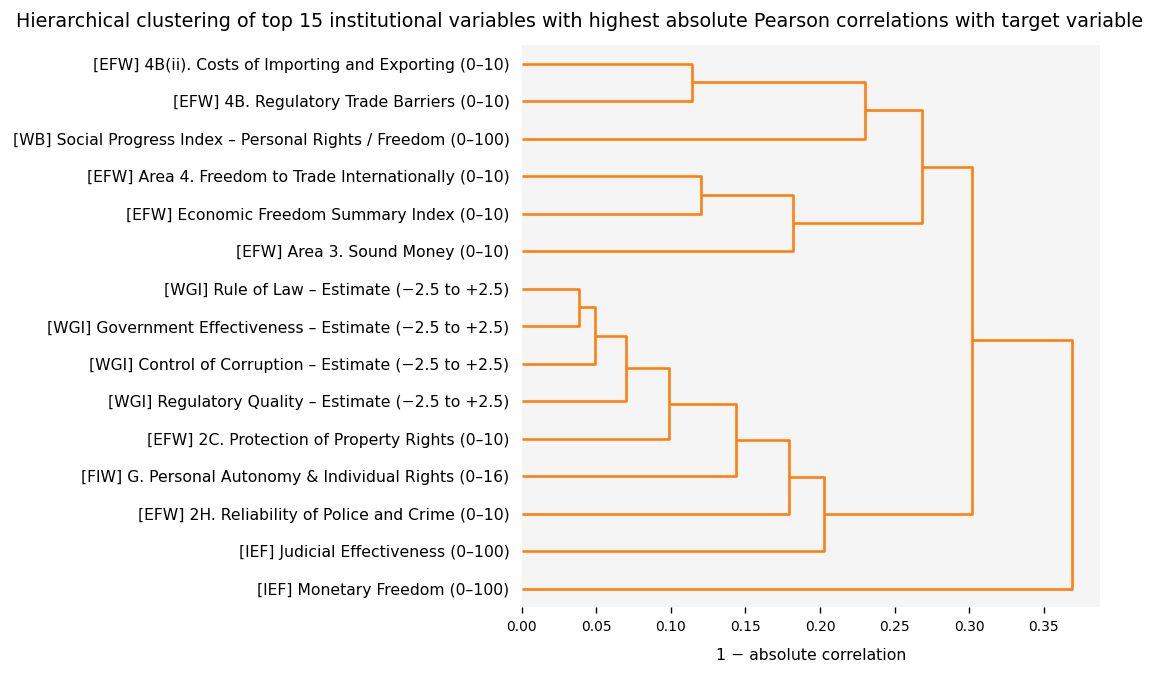

In [ ]:
# dendogram for vars most correlated with target

from functions.plot import dendrogram_for_top_vars

dendrogram_for_top_vars(corr, label_dicts)